In [2]:
import math
import torch
import gpytorch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import GPE_ensemble as GPE

import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
#from GPErks.gp.data.dataset import Dataset
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import LinearMean
from gpytorch.kernels import RBFKernel, ScaleKernel
from torchmetrics import MeanSquaredError, R2Score
#from GPErks.gp.experiment import GPExperiment
#from GPErks.train.emulator import GPEmulator
#from GPErks.perks.inference import Inference
#from GPErks.train.early_stop import NoEarlyStoppingCriterion
#from GPErks.train.early_stop import (
#    GLEarlyStoppingCriterion,
#    PQEarlyStoppingCriterion,
#    UPEarlyStoppingCriterion,
#)
#from GPErks.train.early_stop import PkEarlyStoppingCriterion



%matplotlib inline
%load_ext autoreload
%autoreload 2

# set logger and enforce reproducibility
#from GPErks.log.logger import get_logger
#from GPErks.utils.random import set_seed
#log = get_logger()
seed = 7
#set_seed(seed)

In [3]:
x_labels=pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_5/xlabels.txt',delim_whitespace=True,header=None)


X_all = pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_5/X.txt',index_col=None,delim_whitespace=True,header=None)
X_all.columns=x_labels.values.squeeze().tolist()
print(X_all)

     CV_ventricles  CV_atria     Rsys    Rpulm  a_ventricles  a_atria  \
0         0.760802  0.868096  1.70731  3.62143       3.67702  1.99947   
1         0.644653  0.697527  2.36749  1.86641       1.20492  3.66752   
2         0.652384  0.610575  3.06834  1.55817       1.80784  3.96080   
3         0.615380  0.547748  1.77233  2.63764       2.21983  3.01118   
4         0.454402  0.847549  3.38886  2.27936       2.46983  1.93714   
..             ...       ...      ...      ...           ...      ...   
995       0.548374  1.004190  2.78844  3.18274       2.70849  2.48081   
996       0.567330  0.586630  1.28949  3.35264       3.72868  1.01273   
997       0.541231  0.896994  3.76457  3.87022       1.16020  1.58567   
998       0.457154  0.380562  2.13602  3.28800       3.05301  1.98920   
999       0.592512  0.909685  1.93676  2.39699       4.79355  4.20033   

      EDP_lv   EDP_rv  
0    6.46069  6.92427  
1    1.87275  4.27266  
2    7.47750  7.07723  
3    3.85431  2.32392  
4  

In [4]:
mask = pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_5/output_mask_beat_5.txt',index_col=None,delim_whitespace=True,header=None)

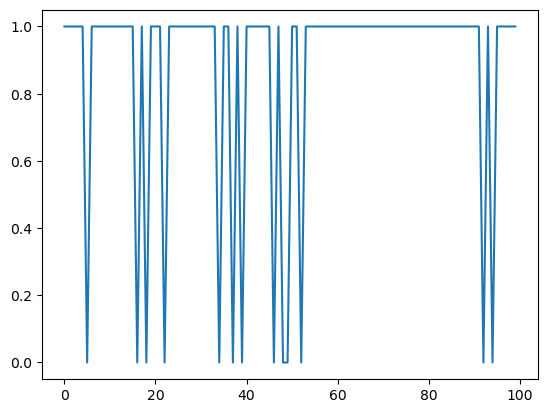

In [5]:
plt.plot(mask)

In [6]:
y_labels=pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_5/ylabels.txt',delim_whitespace=True,header=None)


y_all = pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_5/Y.txt',index_col=None,delim_whitespace=True,header=None)
y_all.columns=y_labels.values.squeeze().tolist()
print(y_all)

     LVedv  LVedp   LVesv  LVpMax  LVdpdtMax  LVdpdtMin   RVedv  RVedp  \
0   140.27   4.61   95.32   75.59       1605       -640  150.44   3.42   
1   178.75   5.19  131.47   94.18       1702       -707  128.45   2.22   
2   146.76   7.00  103.90  107.49       1951       -831  126.61   2.36   
3   146.65   4.44   94.17   85.12       1820       -730  171.00   2.33   
4   167.42   6.11  125.86  107.23       1767       -811  151.82   1.96   
..     ...    ...     ...     ...        ...        ...     ...    ...   
82  151.64   4.88   98.50   74.88       1583       -646  165.61   3.26   
83  148.10   5.74  113.25   95.29       1598       -752  149.28   2.27   
84  140.84   5.58   99.27   83.52       1700       -729  163.45   2.61   
85  136.96   4.70   90.36   66.72       1348       -585  165.91   3.47   
86  157.23   7.49  113.07  102.84       1847       -846  151.89   2.10   

     RVesv  RVpMax  ...  RAvMax  RApMax  LAsvA  LAinflV  LAsvV  RAsvA  \
0   110.87   31.19  ...   90.88    3.8

In [7]:
y_EP = pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_5/Y_EP_beat_5.txt',index_col=None,delim_whitespace=True,header=None)
y_EP.columns=y_labels[26:28]
print(y_EP)

    (A_TAT,)  (V_TAT,)
0     99.641   80.4081
1    125.549   96.2835
2    140.840   95.9221
3    157.538   97.9827
4    103.591  133.2470
..       ...       ...
82   114.734   80.3670
83    86.728  147.2640
84   108.644  107.4810
85    88.786  130.3570
86   267.169   80.2200

[87 rows x 2 columns]


In [16]:
input_masked = X_all.copy().iloc[0:mask.shape[0]]
input_complete=input_masked.copy().iloc[np.array(mask==1),]
input_failed=input_masked.copy().iloc[np.array(mask==0),]

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [18]:
model = LogisticRegression(solver='liblinear', random_state=0)

In [19]:
model.fit(input_masked.values, mask.values.squeeze())

LogisticRegression(random_state=0, solver='liblinear')

In [158]:
reps=50
fail_score = 0
success_score = 0

for j in range(reps):
    complete_input_train=input_complete.sample(11)
    complete_output_train=mask.loc[complete_input_train.index]
    complete_input_test = input_complete.loc[~input_complete.index.isin(complete_input_train.index)]
    complete_output_test = mask.loc[complete_input_test.index]
    for i in range(input_failed.shape[0]):
   
        fail_input_test = input_failed.iloc[[i]]
        fail_output_test = mask.loc[fail_input_test.index]
        fail_input_train=input_failed.loc[~input_failed.index.isin(fail_input_test.index)]
        fail_output_train=mask.loc[fail_input_train.index]

        y_train = pd.concat([fail_output_train,complete_output_train])
        y_test = pd.concat([fail_output_test,complete_output_test])

        x_train = pd.concat([fail_input_train,complete_input_train])
        x_test= pd.concat([fail_input_test,complete_input_test])

        model = LogisticRegression(solver='liblinear', random_state=0)
        model.fit(x_train.values, y_train.values.squeeze())

        success_score+=(1-model.predict(fail_input_test.values))/input_failed.shape[0]/reps
        fail_score+=model.score(complete_input_test.values,complete_output_test.values.squeeze())/reps/input_failed.shape[0]

In [159]:
success_score

array([0.88153846])

In [160]:
fail_score

0.769230769230769

In [161]:
nDim = x_train.shape[1]
boundsMaxMin = []
for i in range(nDim):
    boundsMaxMin.append([np.min(x_train.iloc[:,i]),np.max(x_train.iloc[:,i])])
    print(boundsMaxMin[i])
    

[0.403317, 0.799266]
[0.313459, 1.02094]
[1.06563, 3.82493]
[1.03028, 3.79428]
[1.04432, 4.50538]
[1.04228, 4.96264]
[1.78581, 7.29522]
[1.39586, 6.99168]


In [162]:
##### from SALib.sample import saltelli
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
import numpy as np

# Define the model inputs
problem = {
    'num_vars': nDim,
    'names': x_labels,
    'bounds': boundsMaxMin
    #'bounds': [[-1, 1],
     #          [-1, 1],
      #         [-1, 1],
       #        [-1, 1],
        #       [-1, 1],
         #      [-1, 1],
          #     [-1, 1],
           #    [-1, 1],
            #   [-1,1]]
}

# Generate samples
param_values = saltelli.sample(problem, 1024)

data1 = param_values
#data1.columns = X_train.columns

Ymean=model.predict(data1)

/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_78247/2588839841.py:24: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 1024)


In [163]:
Ymean.shape

(18432,)

In [164]:
np.sum(Ymean)

11667

In [165]:
Si = []
nMod = y_train.shape[1]
nDim = x_train.shape[1]
for i in range(nMod):
    Si.append(sobol.analyze(problem, Ymean, print_to_console=True,calc_second_order=True))

                        ST   ST_conf
(CV_ventricles,)  0.014718  0.010605
(CV_atria,)       0.004205  0.005820
(Rsys,)           0.258616  0.045487
(Rpulm,)          0.084103  0.025577
(a_ventricles,)   0.855745  0.065733
(a_atria,)        0.065180  0.020290
(EDP_lv,)         0.416308  0.047724
(EDP_rv,)         0.126154  0.028326
                        S1   S1_conf
(CV_ventricles,) -0.002662  0.009668
(CV_atria,)       0.003087  0.004272
(Rsys,)           0.080591  0.045737
(Rpulm,)          0.020176  0.023672
(a_ventricles,)   0.534746  0.076327
(a_atria,)        0.003512  0.018768
(EDP_lv,)         0.105978  0.061734
(EDP_rv,)         0.023531  0.031806
Empty DataFrame
Columns: [S2, S2_conf]
Index: []


In [166]:
Si_first=np.zeros((nDim,nMod))
Si_total=np.zeros((nDim,nMod))
for i in range(nMod):
    total_Si, first_Si, second_Si = Si[i].to_df()
    Si_first[:,i] =  first_Si.iloc[:,0]
    Si_total[:,i] =  total_Si.iloc[:,0]

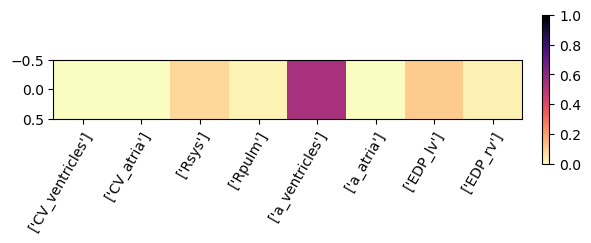

In [168]:
inputs = x_labels.values.tolist()

fig, ax = plt.subplots()
im = ax.imshow(Si_first.T[0:10],cmap='magma_r',vmin=0,vmax=1)


ax.set_xticks(np.arange(len(inputs)), labels=inputs)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

plt.colorbar(im,fraction=0.015, pad=0.04)

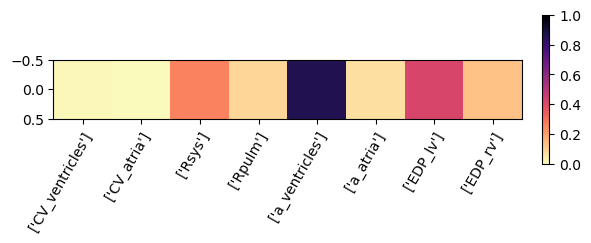

In [167]:
inputs = x_labels.values.tolist()

fig, ax = plt.subplots()
im = ax.imshow(Si_total.T[0:10],cmap='magma_r',vmin=0,vmax=1)


ax.set_xticks(np.arange(len(inputs)), labels=inputs)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

plt.colorbar(im,fraction=0.015, pad=0.04)

In [141]:
np.max(data1[:,4])

4.915119038085938

In [142]:
data2=data1[::20]

Text(0.5, 0, 'EDP_lv')

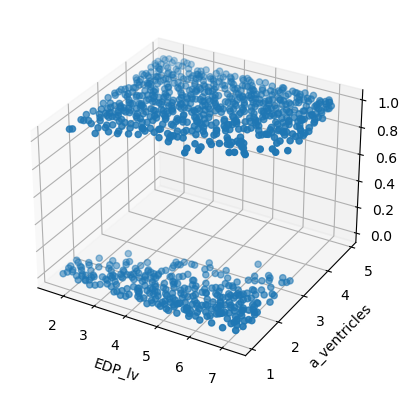

In [143]:
fig = plt.figure()
ax=fig.add_subplot(projection='3d')
ax.scatter(data2[:,6],data2[:,4],model.predict(data2))
plt.ylabel('a_ventricles')
plt.xlabel('EDP_lv')

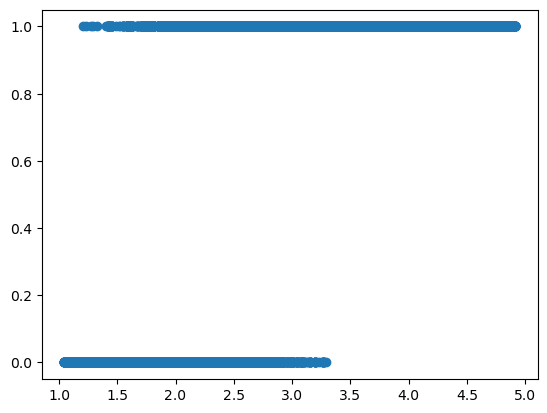

In [144]:
plt.plot(data1[:,4],model.predict(data1),'o')

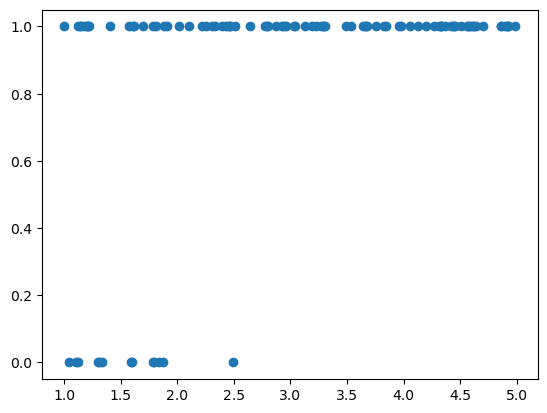

In [145]:
plt.plot(input_masked.iloc[:,4],mask,'o')

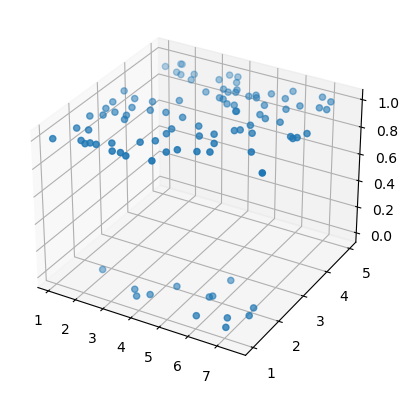

In [146]:
fig = plt.figure()
ax=fig.add_subplot(projection='3d')
ax.scatter(input_masked.iloc[:,6],input_masked.iloc[:,4],mask)

# Emulator

In [26]:
input_masked = X_all.copy().iloc[0:mask.shape[0]]

In [27]:
input_masked=input_masked.iloc[np.array(mask==1),]
input_masked.index = y_all.index

In [172]:
input_masked.shape

(87, 8)

In [173]:
y_all.shape

(87, 28)

In [174]:
y_all.index[0]

0

In [175]:
emulator = GPE.ensemble(input_masked,y_all,mean_func="linear",training_iter=500)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27


In [34]:
nDim = input_masked.shape[1]
boundsMaxMin = []
for i in range(nDim):
    boundsMaxMin.append([np.min(input_masked.iloc[:,i]),np.max(input_masked.iloc[:,i])])
    print(boundsMaxMin[i])

[0.388106, 0.796235]
[0.304348, 1.02094]
[1.02831, 3.93953]
[1.01329, 3.89813]
[1.00155, 4.98784]
[1.19561, 4.99744]
[1.08002, 7.4972]
[1.18509, 7.45226]


In [183]:
##### from SALib.sample import saltelli
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
import numpy as np

# Define the model inputs
problem = {
    'num_vars': nDim,
    'names': x_labels,
    'bounds': boundsMaxMin
    #'bounds': [[-1, 1],
     #          [-1, 1],
      #         [-1, 1],
       #        [-1, 1],
        #       [-1, 1],
         #      [-1, 1],
          #     [-1, 1],
           #    [-1, 1],
            #   [-1,1]]
}

# Generate samples
param_values = saltelli.sample(problem, 1024)

data1 = pd.DataFrame(param_values,columns=input_masked.columns)
#data1.columns = X_train.columns

Ymean=emulator.predict(data1)

/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_78247/4197251896.py:24: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 1024)


In [185]:
Si = []
nMod = y_all.shape[1]
nDim = input_masked.shape[1]
for i in range(nMod):
    Si.append(sobol.analyze(problem, Ymean[:,i].detach().numpy(), print_to_console=True,calc_second_order=True))

                        ST   ST_conf
(CV_ventricles,)  0.000803  0.000124
(CV_atria,)       0.012376  0.001264
(Rsys,)           0.067258  0.007747
(Rpulm,)          0.188605  0.019411
(a_ventricles,)   0.134682  0.021988
(a_atria,)        0.004494  0.000475
(EDP_lv,)         0.636714  0.068086
(EDP_rv,)         0.070683  0.012015
                        S1   S1_conf
(CV_ventricles,)  0.000720  0.002743
(CV_atria,)       0.012023  0.008461
(Rsys,)           0.063735  0.021961
(Rpulm,)          0.184158  0.037894
(a_ventricles,)   0.030717  0.037028
(a_atria,)        0.005007  0.006505
(EDP_lv,)         0.583098  0.065835
(EDP_rv,)         0.056583  0.023297
Empty DataFrame
Columns: [S2, S2_conf]
Index: []
                        ST   ST_conf
(CV_ventricles,)  0.001904  0.000245
(CV_atria,)       0.045131  0.004693
(Rsys,)           0.164647  0.014818
(Rpulm,)          0.661637  0.048353
(a_ventricles,)   0.073984  0.009544
(a_atria,)        0.013987  0.001396
(EDP_lv,)         0.046470

                        ST   ST_conf
(CV_ventricles,)  0.000299  0.000035
(CV_atria,)       0.000396  0.000053
(Rsys,)           0.015946  0.001715
(Rpulm,)          0.305152  0.028929
(a_ventricles,)   0.002831  0.000344
(a_atria,)        0.032541  0.003995
(EDP_lv,)         0.633237  0.051620
(EDP_rv,)         0.038099  0.003992
                        S1   S1_conf
(CV_ventricles,)  0.000049  0.001235
(CV_atria,)       0.000197  0.001586
(Rsys,)           0.011731  0.010522
(Rpulm,)          0.297518  0.042972
(a_ventricles,)   0.002629  0.005487
(a_atria,)        0.004623  0.015174
(EDP_lv,)         0.609665  0.066491
(EDP_rv,)         0.032711  0.015043
Empty DataFrame
Columns: [S2, S2_conf]
Index: []
                        ST   ST_conf
(CV_ventricles,)  0.002835  0.000471
(CV_atria,)       0.063087  0.005400
(Rsys,)           0.175555  0.015796
(Rpulm,)          0.695704  0.050284
(a_ventricles,)   0.019022  0.002513
(a_atria,)        0.007879  0.000859
(EDP_lv,)         0.046697

In [186]:
Si_first=np.zeros((nDim,nMod))
Si_total=np.zeros((nDim,nMod))
for i in range(nMod):
    total_Si, first_Si, second_Si = Si[i].to_df()
    Si_first[:,i] =  first_Si.iloc[:,0]
    Si_total[:,i] =  total_Si.iloc[:,0]


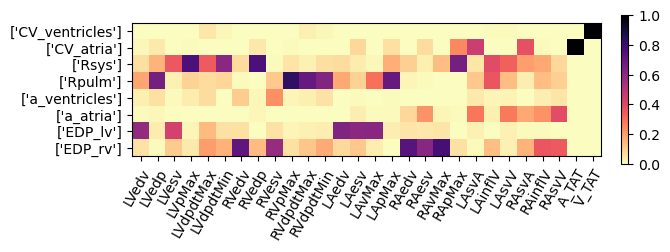

In [197]:
inputs = x_labels.values.tolist()
outputs = y_all.columns.tolist()
fig, ax = plt.subplots()
im = ax.imshow(Si_first[0:28],cmap='magma_r',vmin=0,vmax=1)

ax.set_xticks(np.arange(len(outputs)),labels=outputs)
ax.set_yticks(np.arange(len(inputs)), labels=inputs)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

plt.colorbar(im,fraction=0.015, pad=0.04)

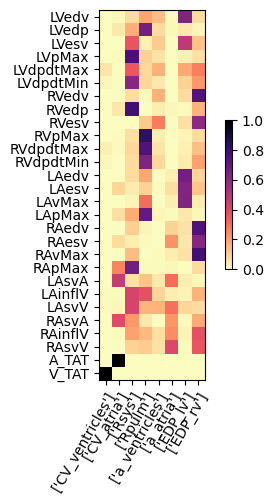

In [193]:
inputs = x_labels.values.tolist()
outputs = y_all.columns.tolist()
fig, ax = plt.subplots()
im = ax.imshow(Si_total.T[0:28],cmap='magma_r',vmin=0,vmax=1)

ax.set_yticks(np.arange(len(outputs)),labels=outputs)
ax.set_xticks(np.arange(len(inputs)), labels=inputs)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

plt.colorbar(im,fraction=0.015, pad=0.04)

In [28]:
nsamp=100
MSE = np.zeros((y_all.shape[0],y_all.shape[1]))

for i in range(y_all.shape[0]):
    y_train = y_all.copy().drop(y_all.index[i])
    X_train = input_masked.copy().drop(y_all.index[i])
    
    y_test = y_all.loc[[y_all.index[i]]]
    X_test = input_masked.loc[[y_all.index[i]]]
    
    emulator = GPE.ensemble(X_train,y_train,mean_func="linear",training_iter=500)
    MSE[i,:] = emulator.MSE(X_test,y_test).detach().numpy()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [29]:
1-MSE.mean(axis=0)/np.var(y_all,axis=0)

LVedv        0.991473
LVedp        0.992461
LVesv        0.992705
LVpMax       0.996580
LVdpdtMax    0.973144
LVdpdtMin    0.991685
RVedv        0.997241
RVedp        0.988384
RVesv        0.998084
RVpMax       0.995260
RVdpdtMax    0.985919
RVdpdtMin    0.993473
LAedv        0.993788
LAesv        0.994648
LAvMax       0.993297
LApMax       0.987907
RAedv        0.994061
RAesv        0.996313
RAvMax       0.995243
RApMax       0.987870
LAsvA        0.993224
LAinflV      0.913807
LAsvV        0.923585
RAsvA        0.974851
RAinflV      0.988207
RAsvV        0.975323
A_TAT        0.999712
V_TAT        0.999583
dtype: float64

In [30]:
MSE.shape

(87, 28)

In [31]:
MSE[0].shape

(28,)

In [32]:
np.var(y_all,axis=0).shape

(28,)

In [33]:
R2=np.zeros((18,28))
for i in range(18):
    R2[i]=(1-MSE[i]/np.var(y_all,axis=0))

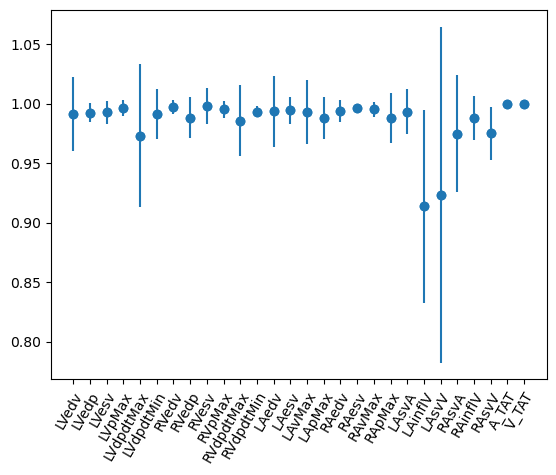

In [34]:
fig, ax = plt.subplots()


ax.scatter(y_labels.values.squeeze(),np.array(1-MSE.mean(axis=0)/np.var(y_all,axis=0)))
plt.errorbar(y_labels.values.squeeze(),np.array(1-MSE.mean(axis=0)/np.var(y_all,axis=0)),fmt='o',yerr=R2.std(axis=0))
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

In [271]:
y_calibration = y_all.loc[:,['V_TAT','LVpMax','LVedv','LVesv']]

In [272]:
y_calibration2 = pd.DataFrame({'LV_EF':(y_all.loc[:,'LVedv']-y_all.loc[:,'LVesv'])/y_all.loc[:,'LVedv']})

In [273]:
y_calibration2=y_calibration.join(y_calibration2)

In [86]:
MSE = np.zeros((y_calibration.shape[0],y_calibration.shape[1]))

for i in range(y_calibration.shape[0]):
    y_train = y_calibration.copy().drop(y_calibration.index[i])
    X_train = input_masked.copy().drop(y_calibration.index[i])
    
    y_test = y_calibration.loc[[y_calibration.index[i]]]
    X_test = input_masked.loc[[y_calibration.index[i]]]
    print(y_test)
    emulator = GPE.ensemble(X_train,y_train,mean_func="linear",training_iter=500)
    MSE[i,:] = emulator.MSE(X_test,y_test).detach().numpy()

     V_TAT  LVpMax   LVedv  LVesv     LV_EF
0  80.4081   75.59  140.27  95.32  0.320453
0
1
2
3
4
     V_TAT  LVpMax   LVedv   LVesv     LV_EF
1  96.2835   94.18  178.75  131.47  0.264503
0
1
2
3
4
     V_TAT  LVpMax   LVedv  LVesv     LV_EF
2  95.9221  107.49  146.76  103.9  0.292041
0
1
2
3
4
     V_TAT  LVpMax   LVedv  LVesv     LV_EF
3  97.9827   85.12  146.65  94.17  0.357859
0
1
2
3
4
     V_TAT  LVpMax   LVedv   LVesv     LV_EF
4  133.247  107.23  167.42  125.86  0.248238
0
1
2
3
4
     V_TAT  LVpMax   LVedv   LVesv    LV_EF
5  121.577   83.75  163.76  111.83  0.31711
0
1
2
3
4
     V_TAT  LVpMax   LVedv  LVesv     LV_EF
6  140.712   65.38  146.28  97.48  0.333607
0
1
2
3
4
     V_TAT  LVpMax   LVedv  LVesv     LV_EF
7  137.839   65.65  132.94  80.19  0.396796
0
1
2
3
4
     V_TAT  LVpMax   LVedv   LVesv     LV_EF
8  100.152   87.01  161.88  112.13  0.307326
0
1
2
3
4
     V_TAT  LVpMax   LVedv   LVesv     LV_EF
9  121.791  104.29  168.05  125.02  0.256055
0
1
2
3
4
      V_TAT 

1
2
3
4
     V_TAT  LVpMax   LVedv  LVesv     LV_EF
82  80.367   74.88  151.64   98.5  0.350435
0
1
2
3
4
      V_TAT  LVpMax  LVedv   LVesv     LV_EF
83  147.264   95.29  148.1  113.25  0.235314
0
1
2
3
4
      V_TAT  LVpMax   LVedv  LVesv     LV_EF
84  107.481   83.52  140.84  99.27  0.295158
0
1
2
3
4
      V_TAT  LVpMax   LVedv  LVesv     LV_EF
85  130.357   66.72  136.96  90.36  0.340245
0
1
2
3
4
    V_TAT  LVpMax   LVedv   LVesv     LV_EF
86  80.22  102.84  157.23  113.07  0.280862
0
1
2
3
4


In [87]:
R2=np.zeros((18,5))
for i in range(18):
    R2[i]=(1-MSE[i]/np.var(y_calibration,axis=0))

In [88]:
R2.std(axis=0)

array([0.00030531, 0.00677318, 0.02753483, 0.0115838 , 0.00358764])

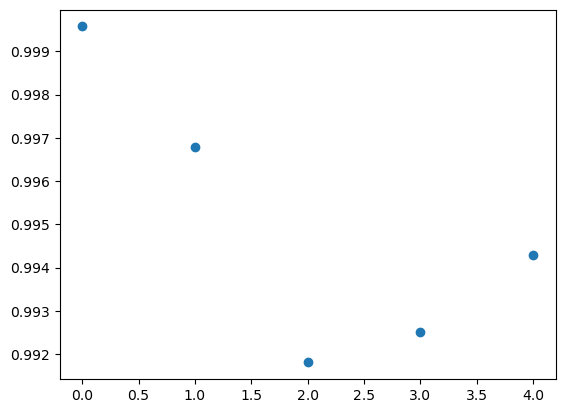

In [89]:
plt.plot(np.array(1-MSE.mean(axis=0)/np.var(y_calibration,axis=0)),'o')

In [90]:
y_calibration.columns.values.tolist()

['V_TAT', 'LVpMax', 'LVedv', 'LVesv', 'LV_EF']

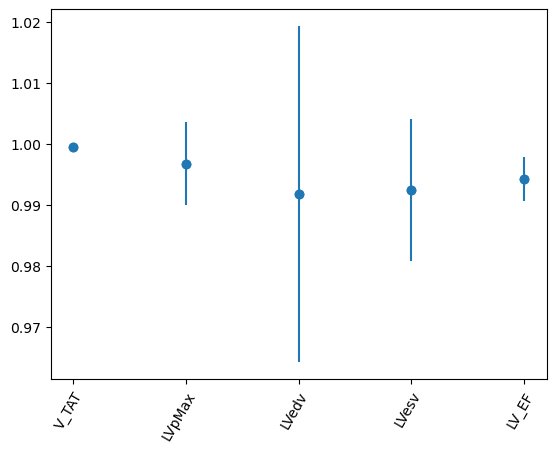

In [91]:
fig, ax = plt.subplots()


ax.scatter(y_calibration.columns.values.tolist(),np.array(1-MSE.mean(axis=0)/np.var(y_calibration,axis=0)))
plt.errorbar(y_calibration.columns.values.tolist(),np.array(1-MSE.mean(axis=0)/np.var(y_calibration,axis=0)),fmt='o',yerr=R2.std(axis=0))
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

In [198]:
X_train = input_masked

In [199]:
y_train=y_calibration

In [200]:
X_train

CV_ventricles  CV_atria     Rsys    Rpulm  a_ventricles  a_atria   EDP_lv  \
0        0.760802  0.868096  1.70731  3.62143       3.67702  1.99947  6.46069   
1        0.644653  0.697527  2.36749  1.86641       1.20492  3.66752  1.87275   
2        0.652384  0.610575  3.06834  1.55817       1.80784  3.96080  7.47750   
3        0.615380  0.547748  1.77233  2.63764       2.21983  3.01118  3.85431   
4        0.454402  0.847549  3.38886  2.27936       2.46983  1.93714  2.19568   
..            ...       ...      ...      ...           ...      ...      ...   
82       0.748546  0.763022  1.37051  2.58230       3.48996  1.73480  3.09983   
83       0.410333  1.000960  3.45345  3.34442       4.32776  4.41315  5.07542   
84       0.558214  0.789336  2.28137  2.95109       4.98784  4.03685  6.82277   
85       0.460975  0.966544  1.31497  3.17083       4.89421  4.68749  7.18945   
86       0.750214  0.324703  2.94926  1.01329       3.97516  4.08164  4.08210   

     EDP_rv  
0   6.92427  
1   4.27266  
2   7.07723  
3   2.32392  
4   3.23450  
..      ...  
82  3.77733  
83  5.64898  
84  4.18600  
85  4.85303  
86  4.15476  

[87 rows x 8 columns]

In [201]:
emulator=GPE.ensemble(X_train,y_train,mean_func="linear",training_iter=500)

0
1
2
3
4


In [33]:
nDim = X_train.shape[1]
boundsMaxMin = []
for i in range(nDim):
    boundsMaxMin.append([np.min(X_train.iloc[:,i]),np.max(X_train.iloc[:,i])])
    print(boundsMaxMin[i])

NameError: name 'X_train' is not defined

In [203]:
##### from SALib.sample import saltelli
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
import numpy as np

# Define the model inputs
problem = {
    'num_vars': nDim,
    'names': x_labels,
    'bounds': boundsMaxMin
    #'bounds': [[-1, 1],
     #          [-1, 1],
      #         [-1, 1],
       #        [-1, 1],
        #       [-1, 1],
         #      [-1, 1],
          #     [-1, 1],
           #    [-1, 1],
            #   [-1,1]]
}

# Generate samples
param_values = saltelli.sample(problem, 1024)

data1 = pd.DataFrame(param_values,columns=X_train.columns)
#data1.columns = X_train.columns

Ymean=emulator.predict(data1)

/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_78247/628021900.py:24: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 1024)


In [204]:
Si = []
nMod = y_train.shape[1]
nDim = X_train.shape[1]
for i in range(nMod):
    Si.append(sobol.analyze(problem, Ymean[:,i].detach().numpy(), print_to_console=True,calc_second_order=True))

                        ST       ST_conf
(CV_ventricles,)  0.995448  5.472829e-02
(CV_atria,)       0.000007  8.775446e-07
(Rsys,)           0.000005  6.999900e-07
(Rpulm,)          0.000014  2.198477e-06
(a_ventricles,)   0.003085  3.462706e-04
(a_atria,)        0.000002  2.598773e-07
(EDP_lv,)         0.000014  2.397935e-06
(EDP_rv,)         0.002756  3.685078e-04
                        S1   S1_conf
(CV_ventricles,)  0.995186  0.062518
(CV_atria,)       0.000025  0.000223
(Rsys,)          -0.000017  0.000220
(Rpulm,)         -0.000033  0.000318
(a_ventricles,)   0.002521  0.004846
(a_atria,)        0.000004  0.000130
(EDP_lv,)         0.000033  0.000298
(EDP_rv,)         0.002173  0.004344
Empty DataFrame
Columns: [S2, S2_conf]
Index: []
                        ST   ST_conf
(CV_ventricles,)  0.003621  0.000328
(CV_atria,)       0.003964  0.000383
(Rsys,)           0.765557  0.055546
(Rpulm,)          0.096464  0.008170
(a_ventricles,)   0.056995  0.006227
(a_atria,)        0.001602 

In [205]:
Si_first=np.zeros((nDim,nMod))
Si_total=np.zeros((nDim,nMod))
for i in range(nMod):
    total_Si, first_Si, second_Si = Si[i].to_df()
    Si_first[:,i] =  first_Si.iloc[:,0]
    Si_total[:,i] =  total_Si.iloc[:,0]


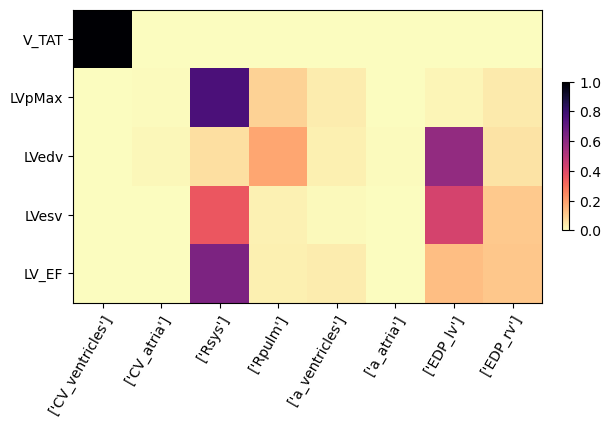

In [206]:
inputs = x_labels.values.tolist()
outputs = y_calibration.columns.tolist()
fig, ax = plt.subplots()
im = ax.imshow(Si_first.T[0:10],cmap='magma_r',vmin=0,vmax=1)

ax.set_yticks(np.arange(len(outputs)),labels=outputs)
ax.set_xticks(np.arange(len(inputs)), labels=inputs)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

plt.colorbar(im,fraction=0.015, pad=0.04)

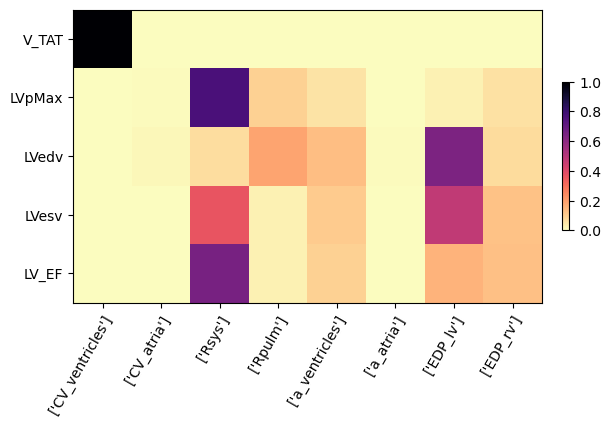

In [207]:
inputs = x_labels.values.tolist()
outputs = y_calibration.columns.tolist()
fig, ax = plt.subplots()
im = ax.imshow(Si_total.T,cmap='magma_r',vmin=0,vmax=1)

ax.set_yticks(np.arange(len(outputs)),labels=outputs)
ax.set_xticks(np.arange(len(inputs)), labels=inputs)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

plt.colorbar(im,fraction=0.015, pad=0.04)

In [208]:
emulator.predict(data1).detach().numpy()[:,4]

array([0.27608645, 0.2824634 , 0.2776903 , ..., 0.2544634 , 0.29685143,
       0.27648908], dtype=float32)

Text(0.5, 0, 'EDP_lv')

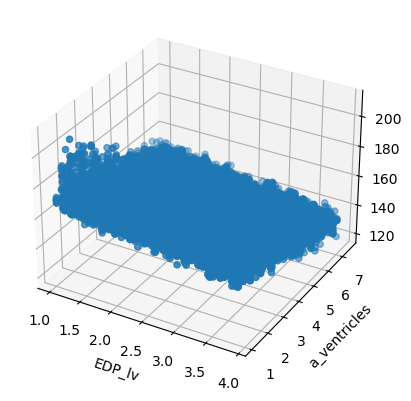

In [209]:
fig = plt.figure()
ax=fig.add_subplot(projection='3d')
ax.scatter(data1.iloc[:,3],data1.iloc[:,6],emulator.predict(data1).detach().numpy()[:,2])
plt.ylabel('a_ventricles')
plt.xlabel('EDP_lv')

In [210]:
Si[i].to_df()

[                        ST   ST_conf
 (CV_ventricles,)  0.003450  0.000330
 (CV_atria,)       0.000712  0.000068
 (Rsys,)           0.649338  0.052321
 (Rpulm,)          0.026969  0.002655
 (a_ventricles,)   0.095432  0.012167
 (a_atria,)        0.000252  0.000037
 (EDP_lv,)         0.159067  0.018559
 (EDP_rv,)         0.129206  0.017664,
                         S1   S1_conf
 (CV_ventricles,)  0.003612  0.005171
 (CV_atria,)       0.000563  0.002228
 (Rsys,)           0.638957  0.063848
 (Rpulm,)          0.027460  0.015687
 (a_ventricles,)   0.036166  0.031160
 (a_atria,)        0.000606  0.001136
 (EDP_lv,)         0.133017  0.031692
 (EDP_rv,)         0.115210  0.030054,
 Empty DataFrame
 Columns: [S2, S2_conf]
 Index: []]

In [211]:
y_calibration

V_TAT  LVpMax   LVedv   LVesv     LV_EF
0    80.4081   75.59  140.27   95.32  0.320453
1    96.2835   94.18  178.75  131.47  0.264503
2    95.9221  107.49  146.76  103.90  0.292041
3    97.9827   85.12  146.65   94.17  0.357859
4   133.2470  107.23  167.42  125.86  0.248238
..       ...     ...     ...     ...       ...
82   80.3670   74.88  151.64   98.50  0.350435
83  147.2640   95.29  148.10  113.25  0.235314
84  107.4810   83.52  140.84   99.27  0.295158
85  130.3570   66.72  136.96   90.36  0.340245
86   80.2200  102.84  157.23  113.07  0.280862

[87 rows x 5 columns]

In [303]:
y_calibration = y_all.loc[:,['V_TAT','LVpMax','LVedv']]

In [304]:
y_calibration2 = pd.DataFrame({'LV_EF':(y_all.loc[:,'LVedv']-y_all.loc[:,'LVesv'])/y_all.loc[:,'LVedv']})

In [305]:
y_calibration=y_calibration.join(y_calibration2)

In [28]:
emulator=GPE.ensemble(input_masked,y_calibration,mean_func="linear",training_iter=500)

0
1
2
3


In [29]:
input_masked

CV_ventricles  CV_atria     Rsys    Rpulm  a_ventricles  a_atria   EDP_lv  \
0        0.760802  0.868096  1.70731  3.62143       3.67702  1.99947  6.46069   
1        0.644653  0.697527  2.36749  1.86641       1.20492  3.66752  1.87275   
2        0.652384  0.610575  3.06834  1.55817       1.80784  3.96080  7.47750   
3        0.615380  0.547748  1.77233  2.63764       2.21983  3.01118  3.85431   
4        0.454402  0.847549  3.38886  2.27936       2.46983  1.93714  2.19568   
..            ...       ...      ...      ...           ...      ...      ...   
82       0.748546  0.763022  1.37051  2.58230       3.48996  1.73480  3.09983   
83       0.410333  1.000960  3.45345  3.34442       4.32776  4.41315  5.07542   
84       0.558214  0.789336  2.28137  2.95109       4.98784  4.03685  6.82277   
85       0.460975  0.966544  1.31497  3.17083       4.89421  4.68749  7.18945   
86       0.750214  0.324703  2.94926  1.01329       3.97516  4.08164  4.08210   

     EDP_rv  
0   6.92427  
1   4.27266  
2   7.07723  
3   2.32392  
4   3.23450  
..      ...  
82  3.77733  
83  5.64898  
84  4.18600  
85  4.85303  
86  4.15476  

[87 rows x 8 columns]

In [54]:
boundsMaxMin

[[0.388106, 0.796235],
 [0.304348, 1.02094],
 [1.02831, 3.93953],
 [1.01329, 3.89813],
 [1.00155, 4.98784],
 [1.19561, 4.99744],
 [1.08002, 7.4972],
 [1.18509, 7.45226]]

In [35]:
centre = (np.array(boundsMaxMin)[:,1]+np.array(boundsMaxMin)[:,0])/2

In [106]:
import emcee
ndim = nDim
nwalkers = 16
p0 = np.random.multivariate_normal(centre, 0.001*np.identity(ndim), size=(nwalkers))
y_val = [100,157,111,0.9]

In [107]:
def log_prior(theta):
    
    #if (np.array(boundsMaxMin)[:,0]<theta).all() and (theta<np.array(boundsMaxMin)[:,1]).all():
        
    if (0<theta).all() and (theta<np.array(boundsMaxMin)[:,1]+20).all():
        return 0.0
    return -np.inf

In [108]:
def log_likelihood(x,emulator,y_val):
    x=pd.DataFrame(x).T
    x.columns = x_labels.values.squeeze().tolist()
    y_val = pd.DataFrame(y_val).T
    y_val.columns = y_calibration.columns.values.squeeze().tolist()
    ll =np.sum(emulator.ensemble_log_likelihood(x,y_val))
    return ll

In [109]:
def log_prob(theta, emulator,y_val):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta,emulator, y_val)

In [110]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[emulator,y_val])

In [111]:
x = np.zeros(8)
x=pd.DataFrame(x).T
x.columns = x_labels.values.squeeze().tolist()

In [112]:
for i in range(16):
    print(log_prob(p0[i],emulator,y_val))

-185889.42881011963
-195683.6259765625
-189547.24920272827
-203929.24267578125
-193095.8761291504
-195962.05493927002
-205127.8599243164
-204767.7925491333
-180478.12354946136
-199405.12536621094
-197702.19232177734
-201154.44807434082
-178897.04873657227
-177312.30429077148
-190386.24716949463
-183796.17643737793


In [113]:
sampler.run_mcmc(p0, 40000)

State([[7.25303384e-01 1.69899389e+01 2.02485506e-01 8.28193955e-01
  1.04043858e+00 8.60954632e-01 2.70050650e+01 1.80375230e-01]
 [7.02447233e-01 1.53582657e+01 1.38177829e-01 5.59198447e-03
  7.64069424e-01 9.72719234e-02 2.70385751e+01 1.56006053e-01]
 [7.20542850e-01 1.65585716e+01 3.48439821e-02 5.13389588e-01
  2.12671436e-02 6.53615503e-01 2.74336593e+01 8.04620337e-01]
 [6.74122117e-01 2.04636156e+01 1.52139291e-02 1.22555362e+00
  7.40803895e-01 1.31552827e+00 2.74905466e+01 2.29569936e-03]
 [6.92595669e-01 1.60312776e+01 1.73317882e-01 1.84881087e-01
  1.08720954e-01 2.59866670e+00 2.74955089e+01 2.10647260e-02]
 [6.84301615e-01 1.55697914e+01 1.97715789e-01 5.42290570e-01
  5.97877887e-01 2.05662296e+00 2.74307292e+01 5.33908396e-03]
 [7.32225445e-01 1.74387883e+01 9.91353292e-02 6.46959806e-02
  2.36090457e-01 1.04896292e+01 2.74370785e+01 1.12586524e-02]
 [7.30220864e-01 1.63862299e+01 8.28159887e-02 3.40745598e-01
  2.09511926e-01 9.39279123e-01 2.74387043e+01 1.13504458

In [114]:
flat_samples = sampler.get_chain(discard=6000, thin=10, flat=True)
print(flat_samples.shape)

(54400, 8)


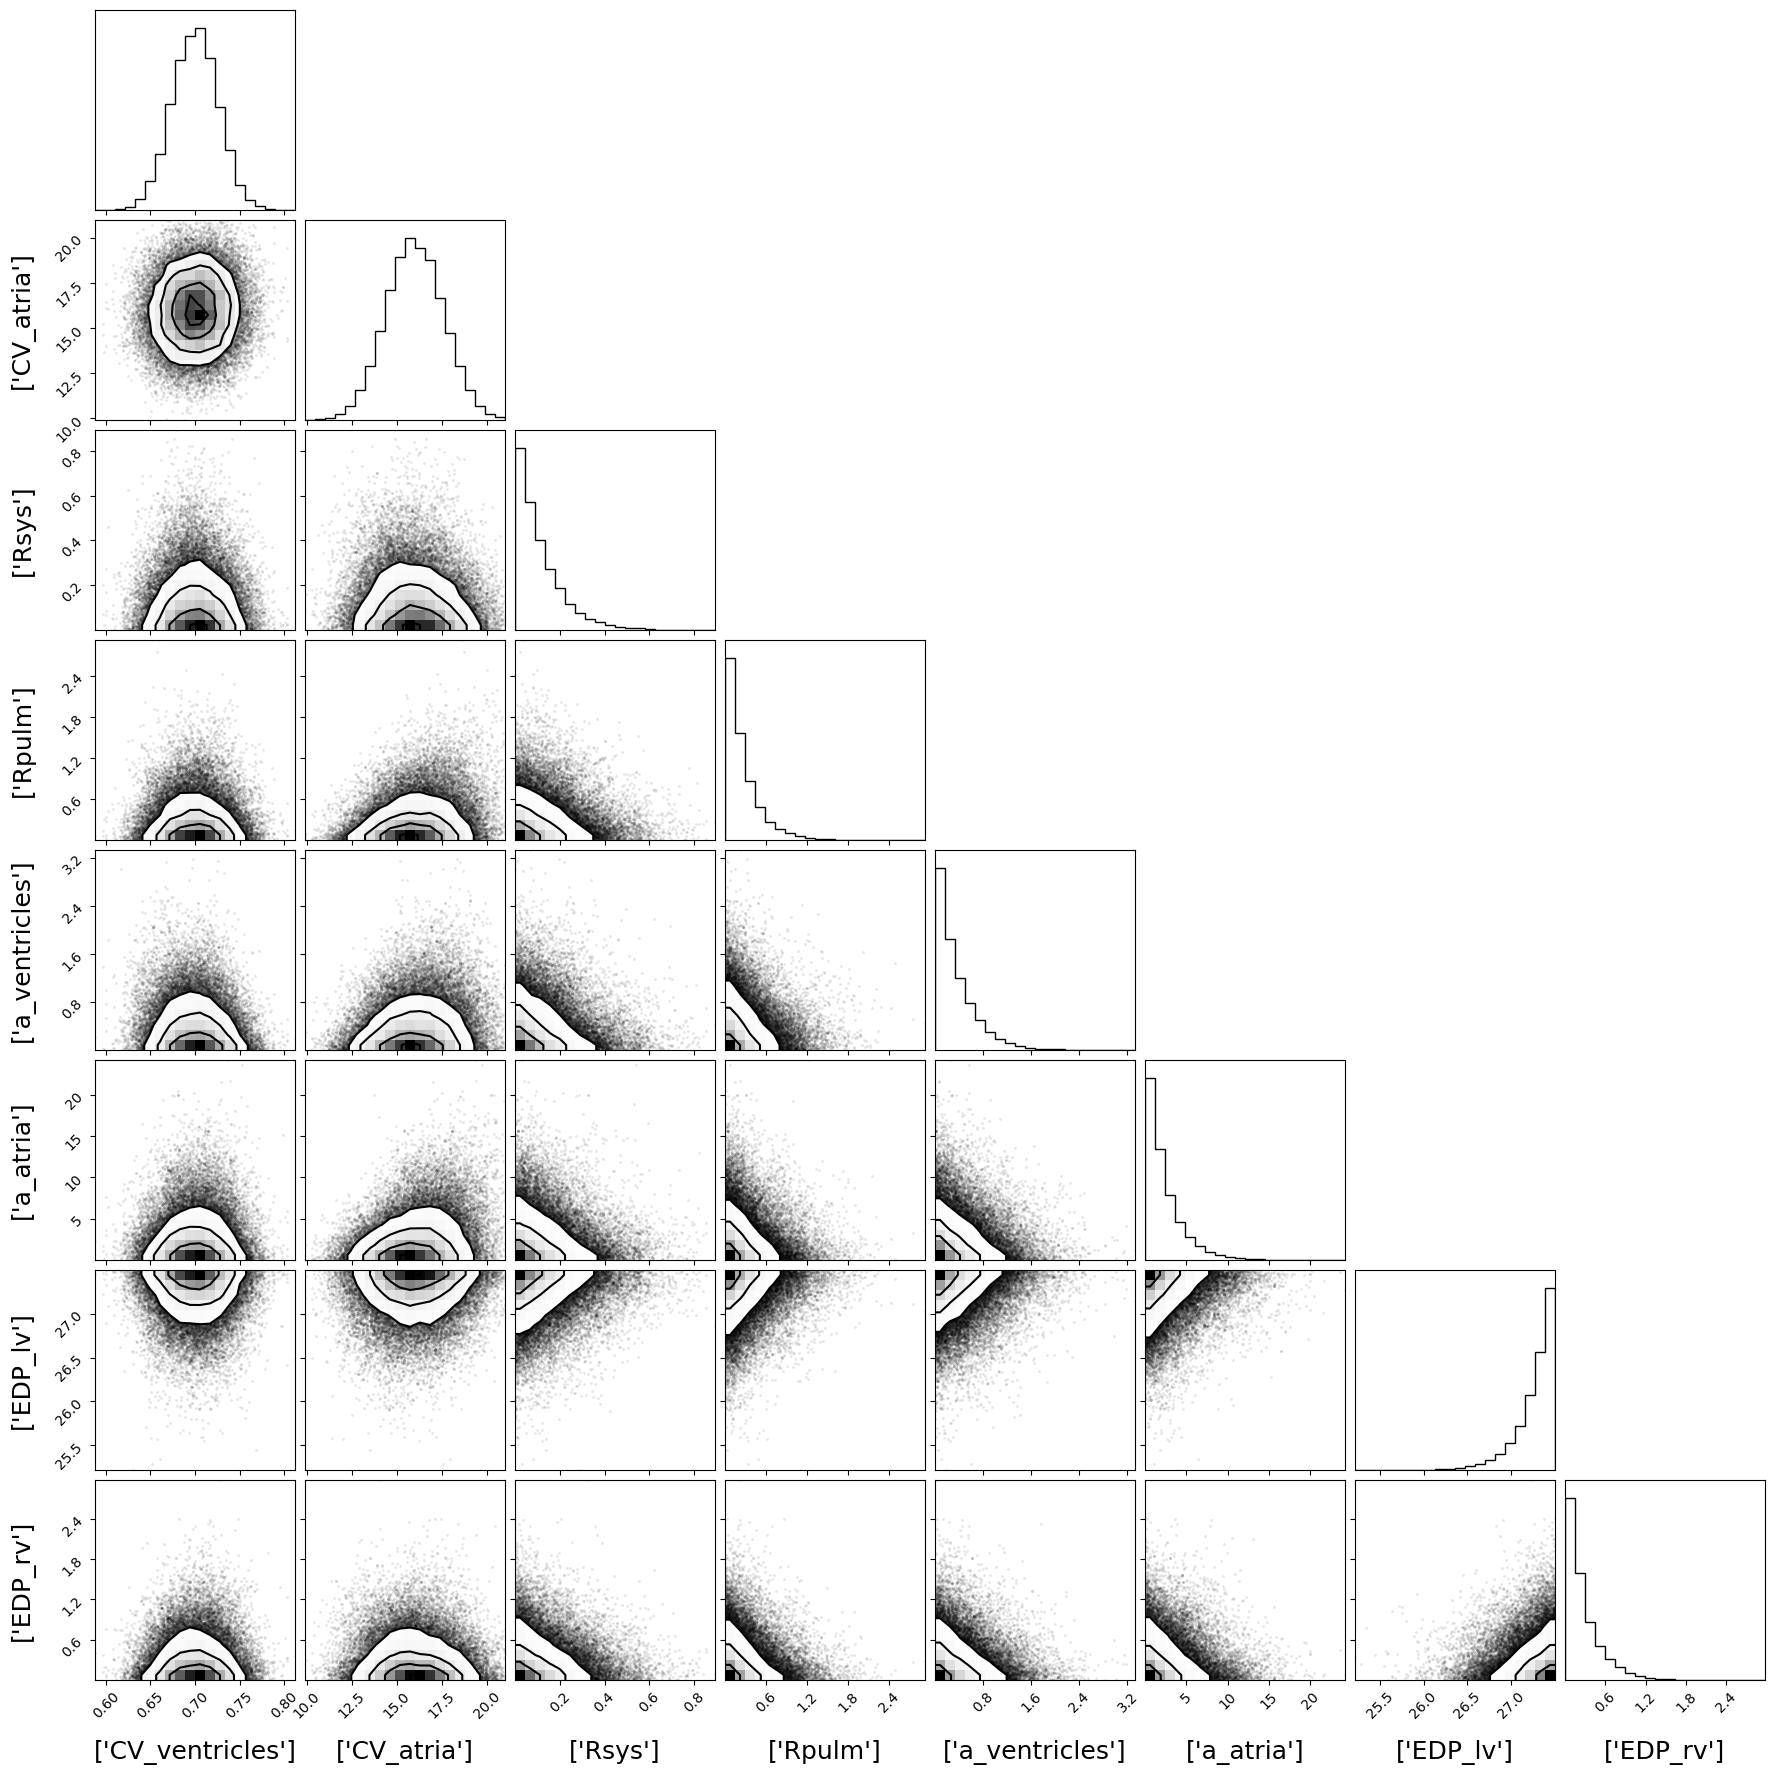

In [115]:
import corner

fig = corner.corner(
    flat_samples, labels=x_labels.values, label_kwargs=dict(fontsize=18)
);

In [116]:
samp = pd.DataFrame(flat_samples).sample(50)

In [117]:
samp.to_csv("MCMC_samples_scenario_5_90.dat", sep = " ",index=False,header=None)

In [118]:
flat_samples.mean(axis=0)

array([ 0.69988059, 16.00337071,  0.11159588,  0.26013887,  0.35447665,
        2.37244136, 27.26561027,  0.27133531])

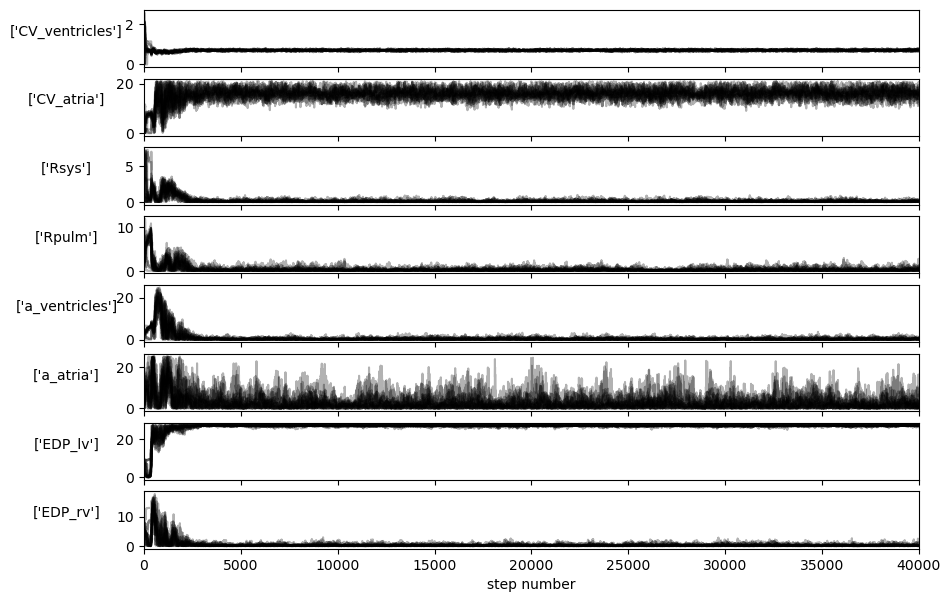

In [119]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = x_labels.values
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i],rotation=0)
    ax.yaxis.set_label_coords(-0.1, 0.5)


axes[-1].set_xlabel("step number");

In [120]:
x_out = pd.DataFrame(flat_samples.mean(axis=0)).T
x_out.columns = x_labels.values.squeeze()

In [121]:
y_calibration.columns

Index(['V_TAT', 'LVpMax', 'LVedv', 'LV_EF'], dtype='object')

In [125]:
emulator.predict(x_out)

tensor([[ 98.5925, 126.8686, 134.5605,   0.7214]], grad_fn=<PermuteBackward0>)

(array([4.0000e+00, 2.0000e+01, 1.2800e+02, 6.0700e+02, 2.4070e+03,
        7.9800e+03, 1.7888e+04, 1.9471e+04, 5.5650e+03, 3.3000e+02]),
 array([0.66710377, 0.6750862 , 0.68306863, 0.69105113, 0.69903356,
        0.70701599, 0.71499842, 0.72298086, 0.73096335, 0.73894578,
        0.74692822]),
 <BarContainer object of 10 artists>)

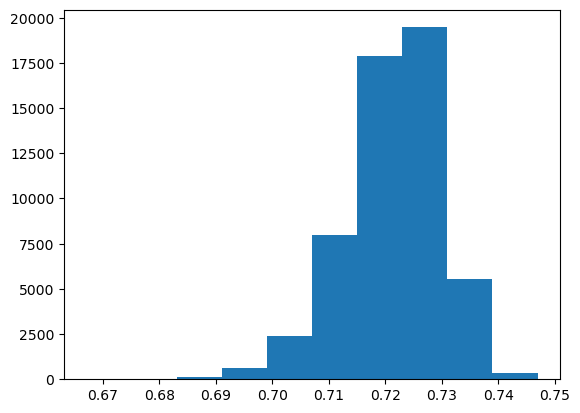

In [126]:
plt.hist(emulator.predict(pd.DataFrame(flat_samples,columns=input_masked.columns))[:,3].detach().numpy())

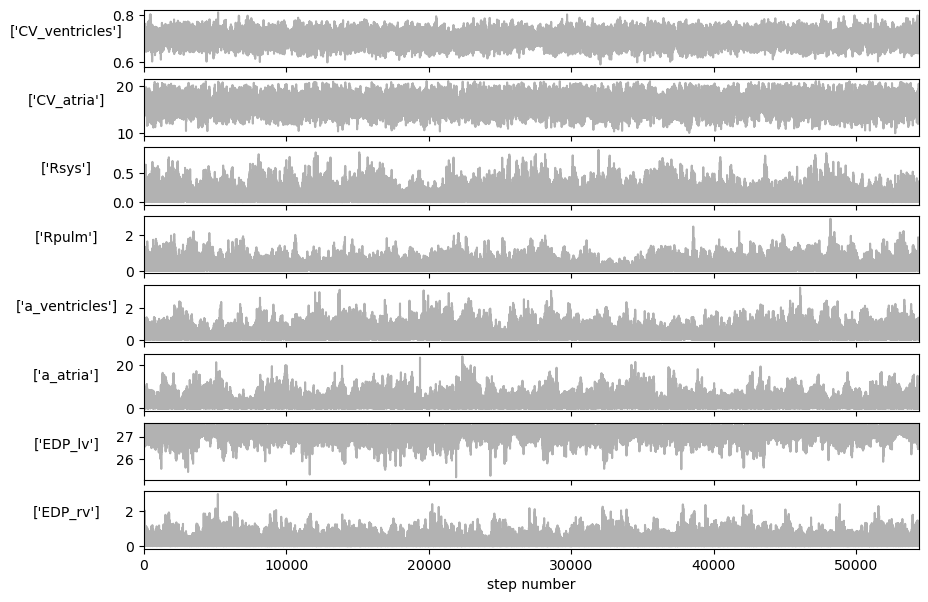

In [124]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = flat_samples
labels = x_labels.values
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i],rotation=0)
    ax.yaxis.set_label_coords(-0.1, 0.5)


axes[-1].set_xlabel("step number");

# Calibration with fixed inputs

In [383]:
new_input=input_masked.copy()
new_input=new_input.drop(['CV_atria','a_atria','a_ventricles'],axis=1)

In [384]:
emulator = GPE.ensemble(new_input,y_calibration,mean_func="linear",training_iter=500)

0
1
2
3


In [385]:
nDim = new_input.shape[1]
boundsMaxMin = []
for i in range(nDim):
    boundsMaxMin.append([np.min(new_input.iloc[:,i]),np.max(new_input.iloc[:,i])])
    print(boundsMaxMin[i])

[0.388106, 0.796235]
[1.02831, 3.93953]
[1.01329, 3.89813]
[1.08002, 7.4972]
[1.18509, 7.45226]


# Multi-Output GP

In [306]:
import mogptk

In [345]:
y_calibration

V_TAT  LVpMax   LVedv     LV_EF
0    80.4081   75.59  140.27  0.320453
1    96.2835   94.18  178.75  0.264503
2    95.9221  107.49  146.76  0.292041
3    97.9827   85.12  146.65  0.357859
4   133.2470  107.23  167.42  0.248238
..       ...     ...     ...       ...
82   80.3670   74.88  151.64  0.350435
83  147.2640   95.29  148.10  0.235314
84  107.4810   83.52  140.84  0.295158
85  130.3570   66.72  136.96  0.340245
86   80.2200  102.84  157.23  0.280862

[87 rows x 4 columns]

In [337]:
# split original dataset in training, validation and testing sets
X=input_masked
y=y_calibration
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=seed
)

In [338]:
MOData = pd.concat((X_train,y_train),axis=1)


In [339]:
MOData

CV_ventricles  CV_atria     Rsys    Rpulm  a_ventricles  a_atria   EDP_lv  \
64       0.677950  0.463757  3.59444  3.85526       4.70216  4.23737  4.03634   
30       0.491283  0.689579  1.99546  2.27022       4.19416  3.17899  6.22207   
22       0.599610  0.929227  2.00773  2.49118       2.42861  1.45264  3.83738   
27       0.491409  0.985488  2.06718  2.27277       4.61212  4.61397  1.51899   
45       0.634191  0.328338  1.83396  2.46341       4.57648  4.73665  5.87253   
..            ...       ...      ...      ...           ...      ...      ...   
23       0.705182  0.450477  2.87816  1.52528       3.19342  3.96461  2.42071   
67       0.416699  0.607350  1.23506  3.65369       4.91701  2.63995  3.59100   
25       0.774835  0.773600  2.83647  3.72830       4.36343  4.15697  2.70487   
68       0.684191  0.827972  1.22443  2.08662       1.90849  4.99744  5.20143   
47       0.435220  0.739517  1.87694  3.08756       2.77927  1.32831  4.45220   

     EDP_rv     V_TAT  LVpMax   LVedv     LV_EF  
64  1.18509   87.8938   95.51  143.79  0.237499  
30  4.11682  122.3920   83.24  144.30  0.321067  
22  5.95879  102.6680   86.06  157.39  0.303958  
27  5.49587  123.0630   80.82  159.25  0.276107  
45  7.13465   95.4719   76.21  143.32  0.303586  
..      ...       ...     ...     ...       ...  
23  2.82968   85.1163  102.69  161.66  0.280032  
67  4.44165  144.3540   63.62  143.97  0.320067  
25  1.71504   77.1013   90.38  148.49  0.262577  
68  7.41615   91.9244   71.60  148.47  0.360073  
47  5.83757  140.8180   79.85  149.56  0.307101  

[69 rows x 12 columns]

In [340]:
y_calibration2.columns.values.tolist()

['LV_EF']

In [341]:
dataset = mogptk.LoadDataFrame(MOData,x_col=input_masked.columns.values.tolist(),y_col=y_calibration2.columns.values.tolist())
dataset.transform(mogptk.TransformNormalize)
dataset

    CV_ventricles  CV_atria     Rsys    Rpulm  a_ventricles  a_atria   EDP_lv  \
0        0.677950  0.463757  3.59444  3.85526       4.70216  4.23737  4.03634   
1        0.491283  0.689579  1.99546  2.27022       4.19416  3.17899  6.22207   
2        0.599610  0.929227  2.00773  2.49118       2.42861  1.45264  3.83738   
3        0.491409  0.985488  2.06718  2.27277       4.61212  4.61397  1.51899   
4        0.634191  0.328338  1.83396  2.46341       4.57648  4.73665  5.87253   
..            ...       ...      ...      ...           ...      ...      ...   
64       0.705182  0.450477  2.87816  1.52528       3.19342  3.96461  2.42071   
65       0.416699  0.607350  1.23506  3.65369       4.91701  2.63995  3.59100   
66       0.774835  0.773600  2.83647  3.72830       4.36343  4.15697  2.70487   
67       0.684191  0.827972  1.22443  2.08662       1.90849  4.99744  5.20143   
68       0.435220  0.739517  1.87694  3.08756       2.77927  1.32831  4.45220   

     EDP_rv     LV_EF  
0  

In [342]:
dataset.get_test_data()

(array([], shape=(0, 8), dtype=float64), array([], dtype=float64))

In [343]:
# create model, uncomment for different kernels 
#model = mogptk.MOSM(dataset, Q=2)
#model = mogptk.CSM(dataset, Q=4)
#model = mogptk.SM_LMC(dataset, Q=4)
model = mogptk.CONV(dataset, Q=4)

# initialize parameters of kernel using LombScargle
model.init_parameters(method='LS', iters=500)

Starting optimization using Adam
‣ Model: Exact
  ‣ Kernel: [GaussianConvolutionProcessKernel,GaussianConvolutionProcessKernel,GaussianConvolutionProcessKernel,GaussianConvolutionProcessKernel]
  ‣ Likelihood: GaussianLikelihood
‣ Channels: 1
‣ Parameters: 69
‣ Training points: 69
‣ Iterations: 7000
     0/7000   0:00:00  loss=     44.3974  error=  0.00211935 (warmup)
  1973/7000   0:00:10  loss=    -85.7847  error= 1.64936e-11
  3981/7000   0:00:20  loss=    -91.7651  error= 6.63672e-13
  5986/7000   0:00:30  loss=     -94.657  error=  8.2787e-14
  7000/7000   0:00:35  loss=    -95.7065  error= 3.69787e-14
Optimization finished in 35.016 seconds


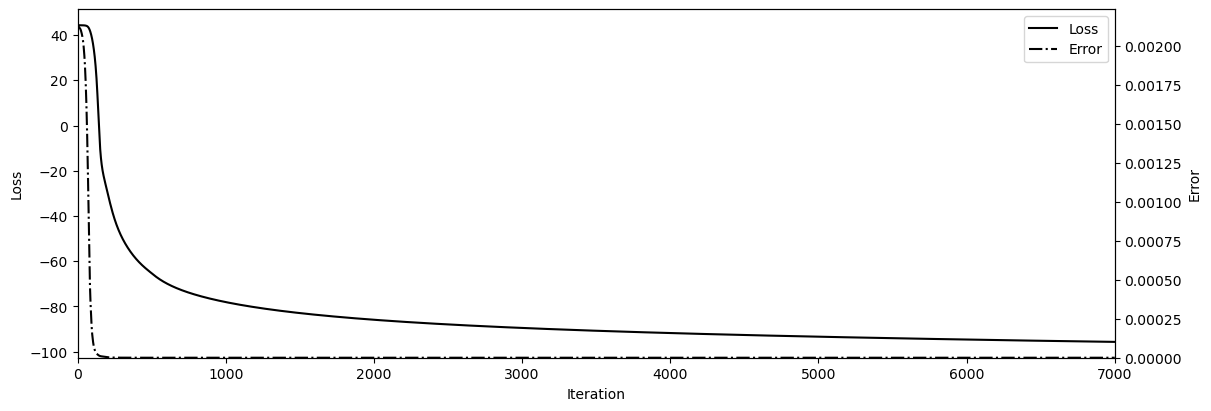

In [344]:
model.train(method='Adam', lr=0.1, iters=7000, plot=True, error='MSE', verbose=True);

In [332]:
model.predict(X_test.values)[1]

array([0.36370145, 0.31362547, 0.18997915, 0.20341557, 0.25398283,
       0.28620659, 0.28913971, 0.29352189, 0.30775731, 0.29413688,
       0.25089431, 0.31760966, 0.33412695, 0.33471313, 0.3382253 ,
       0.31872621, 0.28662171, 0.40255031])

In [333]:
np.mean((y_test.values.T-model.predict(X_test.values)[1])**2,axis=1)/X_test.shape[0]

array([1.00393194e-06])

In [334]:
emulator = GPE.ensemble(X_train,y_train,mean_func="linear",training_iter=1000)

0


In [335]:
emulator.MSE(X_test,y_test)

tensor([1.1795e-05], dtype=torch.float64, grad_fn=<MeanBackward1>)

(<Figure size 1200x1200 with 1 Axes>, <Axes: >)

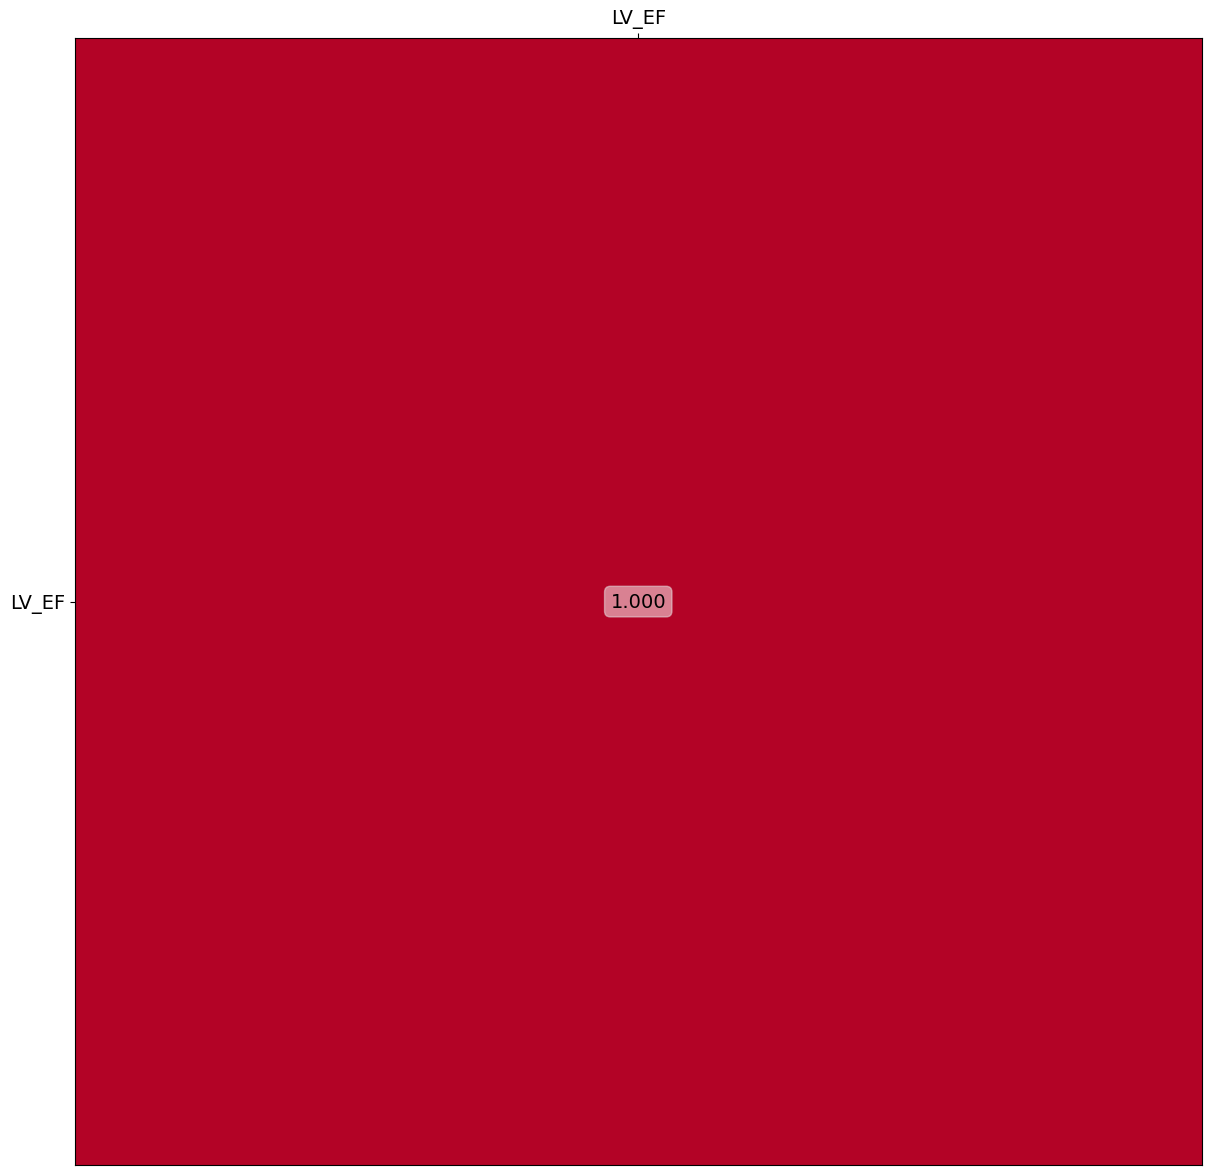

In [336]:
model.plot_correlation()

In [164]:
model.print_parameters()

In [148]:
params?

In [152]:
params = []

for p in model.parameters():
    params.append(p)

In [161]:
params

[MixtureKernel[0].GaussianConvolutionProcessKernel.weight=[3.7799266699197545, 7.679173579530634, 28.922988214302777, 8.879633206709755],
 MixtureKernel[0].GaussianConvolutionProcessKernel.variance=[[0.0009756545815890106, 0.0, 0.0, 0.0, 27819.543719613113, 0.0, 0.0, 0.0], [1.7460115277182566, 0.0, 0.0, 119410.25481699423, 0.0, 0.0, 0.0, 0.0], [11.369120898808664, 115237.02973475368, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.6990749064961943, 0.0, 0.0, 74757.56112865475, 0.0, 0.0, 0.0, 0.0]],
 MixtureKernel[0].GaussianConvolutionProcessKernel.base_variance=[0.027349248580035165, 45.2869306405704, 50.20235666126738, 52.545165282041715, 4.912158401464083, 52.8947218962032, 39.88119030387237, 45.07202160815998],
 MixtureKernel[1].GaussianConvolutionProcessKernel.weight=[0.06271293360613353, 0.0036540331865213675, 0.002680603162650705, 0.7073596511471558],
 MixtureKernel[1].GaussianConvolutionProcessKernel.variance=[[10.162908005474888, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [37.97208882285453, 0.0, 

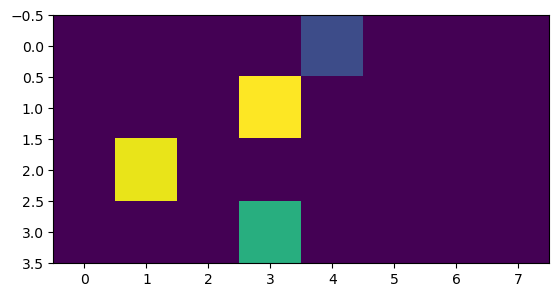

In [157]:
plt.imshow([[0.0009756545815890106, 0.0, 0.0, 0.0, 27819.543719613113, 0.0, 0.0, 0.0], [1.7460115277182566, 0.0, 0.0, 119410.25481699423, 0.0, 0.0, 0.0, 0.0], [11.369120898808664, 115237.02973475368, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.6990749064961943, 0.0, 0.0, 74757.56112865475, 0.0, 0.0, 0.0, 0.0]])

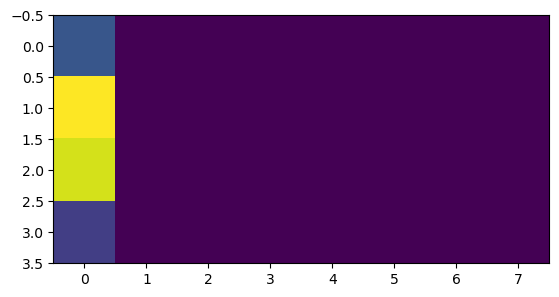

In [162]:
plt.imshow([[10.162908005474888, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [37.97208882285453, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [35.583222651507306, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [7.01360765548753, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]])

In [352]:
# split original dataset in training, validation and testing sets
X=input_masked
y=y_all
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=seed
)

In [353]:
MOData = pd.concat((X_train,y_train),axis=1)


In [354]:
MOData

CV_ventricles  CV_atria     Rsys    Rpulm  a_ventricles  a_atria   EDP_lv  \
64       0.677950  0.463757  3.59444  3.85526       4.70216  4.23737  4.03634   
30       0.491283  0.689579  1.99546  2.27022       4.19416  3.17899  6.22207   
22       0.599610  0.929227  2.00773  2.49118       2.42861  1.45264  3.83738   
27       0.491409  0.985488  2.06718  2.27277       4.61212  4.61397  1.51899   
45       0.634191  0.328338  1.83396  2.46341       4.57648  4.73665  5.87253   
..            ...       ...      ...      ...           ...      ...      ...   
23       0.705182  0.450477  2.87816  1.52528       3.19342  3.96461  2.42071   
67       0.416699  0.607350  1.23506  3.65369       4.91701  2.63995  3.59100   
25       0.774835  0.773600  2.83647  3.72830       4.36343  4.15697  2.70487   
68       0.684191  0.827972  1.22443  2.08662       1.90849  4.99744  5.20143   
47       0.435220  0.739517  1.87694  3.08756       2.77927  1.32831  4.45220   

     EDP_rv   LVedv  LVedp  ...  RAvMax  RApMax  LAsvA  LAinflV  LAsvV  RAsvA  \
64  1.18509  143.79   4.39  ...  104.62    1.86   6.93     7.45  10.80   7.79   
30  4.11682  144.30   6.12  ...  100.02    2.94  10.19     9.94  13.14  10.14   
22  5.95879  157.39   5.58  ...   88.51    3.56  16.33    10.35  16.83  11.74   
27  5.49587  159.25   5.69  ...   92.86    3.20  11.05     9.37  13.16   9.04   
45  7.13465  143.32   4.85  ...   92.26    2.83   4.94     8.50  11.98   4.83   
..      ...     ...    ...  ...     ...     ...    ...      ...    ...    ...   
23  2.82968  161.66   6.33  ...   99.23    1.96   9.46    11.40  14.81   7.21   
67  4.44165  143.97   3.54  ...   99.93    3.58   8.11    10.34  15.07  11.53   
25  1.71504  148.49   4.35  ...  103.86    2.50   9.57     8.60  12.50  10.03   
68  7.41615  148.47   5.17  ...   93.58    4.04   9.49    10.73  13.44   9.41   
47  5.83757  149.56   4.94  ...   89.84    3.40  13.13     9.89  16.34  11.88   

    RAinflV  RAsvV    A_TAT     V_TAT  
64     9.53  11.98  187.328   87.8938  
30    11.78  13.83  124.241  122.3920  
22    12.25  14.78   93.380  102.6680  
27     9.60  11.18   90.071  123.0630  
45     9.16  10.13  264.580   95.4719  
..      ...    ...      ...       ...  
23    11.38  13.48  193.507   85.1163  
67    11.20  14.41  144.004  144.3540  
25    10.44  12.52  112.601   77.1013  
68     9.85  10.56  105.052   91.9244  
47    11.94  14.13  117.359  140.8180  

[69 rows x 36 columns]

In [355]:
y_calibration.columns.values.tolist()

['V_TAT', 'LVpMax', 'LVedv', 'LV_EF']

In [356]:
dataset = mogptk.LoadDataFrame(MOData,x_col=input_masked.columns.values.tolist(),y_col=y_all.columns.values.tolist())
dataset.transform(mogptk.TransformNormalize)
dataset

    CV_ventricles  CV_atria     Rsys    Rpulm  a_ventricles  a_atria   EDP_lv  \
0        0.677950  0.463757  3.59444  3.85526       4.70216  4.23737  4.03634   
1        0.491283  0.689579  1.99546  2.27022       4.19416  3.17899  6.22207   
2        0.599610  0.929227  2.00773  2.49118       2.42861  1.45264  3.83738   
3        0.491409  0.985488  2.06718  2.27277       4.61212  4.61397  1.51899   
4        0.634191  0.328338  1.83396  2.46341       4.57648  4.73665  5.87253   
..            ...       ...      ...      ...           ...      ...      ...   
64       0.705182  0.450477  2.87816  1.52528       3.19342  3.96461  2.42071   
65       0.416699  0.607350  1.23506  3.65369       4.91701  2.63995  3.59100   
66       0.774835  0.773600  2.83647  3.72830       4.36343  4.15697  2.70487   
67       0.684191  0.827972  1.22443  2.08662       1.90849  4.99744  5.20143   
68       0.435220  0.739517  1.87694  3.08756       2.77927  1.32831  4.45220   

     EDP_rv   LVedv  
0   1

In [357]:
dataset.get_test_data()

([array([], shape=(0, 8), dtype=float64),
  array([], shape=(0, 8), dtype=float64),
  array([], shape=(0, 8), dtype=float64),
  array([], shape=(0, 8), dtype=float64),
  array([], shape=(0, 8), dtype=float64),
  array([], shape=(0, 8), dtype=float64),
  array([], shape=(0, 8), dtype=float64),
  array([], shape=(0, 8), dtype=float64),
  array([], shape=(0, 8), dtype=float64),
  array([], shape=(0, 8), dtype=float64),
  array([], shape=(0, 8), dtype=float64),
  array([], shape=(0, 8), dtype=float64),
  array([], shape=(0, 8), dtype=float64),
  array([], shape=(0, 8), dtype=float64),
  array([], shape=(0, 8), dtype=float64),
  array([], shape=(0, 8), dtype=float64),
  array([], shape=(0, 8), dtype=float64),
  array([], shape=(0, 8), dtype=float64),
  array([], shape=(0, 8), dtype=float64),
  array([], shape=(0, 8), dtype=float64),
  array([], shape=(0, 8), dtype=float64),
  array([], shape=(0, 8), dtype=float64),
  array([], shape=(0, 8), dtype=float64),
  array([], shape=(0, 8), dtype=fl

In [360]:
# create model, uncomment for different kernels 
#model = mogptk.MOSM(dataset, Q=2)
#model = mogptk.CSM(dataset, Q=4)
#model = mogptk.SM_LMC(dataset, Q=4)
model = mogptk.CONV(dataset, Q=2)

# initialize parameters of kernel using LombScargle
model.init_parameters(method='LS', iters=500)

Starting optimization using SGD
‣ Model: Exact
  ‣ Kernel: [GaussianConvolutionProcessKernel,GaussianConvolutionProcessKernel]
  ‣ Likelihood: GaussianLikelihood
‣ Channels: 28
‣ Parameters: 548
‣ Training points: 1932
‣ Iterations: 3500
     0/3500   0:00:15  loss=     1425.16  error=     2009.97 (warmup)
     2/3500   0:00:21  loss=     1423.68  error=     2010.82
     5/3500   0:00:30  loss=     1421.63  error=     2012.04
     8/3500   0:00:40  loss=     1419.77  error=     2013.19
    11/3500   0:00:50  loss=     1418.06  error=     2014.28
    15/3500   0:01:03  loss=     1416.01  error=     2015.66
    18/3500   0:01:12  loss=     1414.61  error=     2016.63
    21/3500   0:01:22  loss=     1413.32  error=     2017.56
    24/3500   0:01:32  loss=     1412.12  error=     2018.44
    27/3500   0:01:42  loss=     1411.01  error=     2019.29
    30/3500   0:01:52  loss=     1409.98  error=      2020.1
    33/3500   0:02:02  loss=     1409.01  error=     2020.88
    36/3500   0:02:12

   365/3500   0:22:03  loss=      1373.1  error=     2033.84
   367/3500   0:22:10  loss=     1372.94  error=     2033.74
   370/3500   0:22:21  loss=     1372.71  error=     2033.59
   373/3500   0:22:32  loss=     1372.47  error=     2033.43
   376/3500   0:22:43  loss=     1372.24  error=     2033.27
   378/3500   0:22:50  loss=     1372.08  error=     2033.16
   381/3500   0:23:01  loss=     1371.84  error=        2033
   384/3500   0:23:13  loss=     1371.61  error=     2032.83
   386/3500   0:23:20  loss=     1371.45  error=     2032.72
   389/3500   0:23:31  loss=     1371.21  error=     2032.55
   392/3500   0:23:42  loss=     1370.98  error=     2032.38
   394/3500   0:23:50  loss=     1370.82  error=     2032.27
   397/3500   0:24:01  loss=     1370.58  error=      2032.1
   400/3500   0:24:12  loss=     1370.35  error=     2031.92
   402/3500   0:24:20  loss=     1370.19  error=      2031.8
   405/3500   0:24:31  loss=     1369.95  error=     2031.63
   408/3500   0:24:42  l

   739/3500   0:44:30  loss=     1335.52  error=     1999.61
   743/3500   0:44:43  loss=     1334.94  error=        1999
   746/3500   0:44:52  loss=     1334.49  error=     1998.54
   749/3500   0:45:02  loss=     1334.05  error=     1998.08
   752/3500   0:45:12  loss=      1333.6  error=     1997.61
   755/3500   0:45:22  loss=     1333.14  error=     1997.13
   758/3500   0:45:32  loss=     1332.69  error=     1996.65
   761/3500   0:45:42  loss=     1332.23  error=     1996.17
   764/3500   0:45:52  loss=     1331.77  error=     1995.68
   767/3500   0:46:02  loss=      1331.3  error=     1995.18
   770/3500   0:46:11  loss=     1330.83  error=     1994.68
   773/3500   0:46:21  loss=     1330.36  error=     1994.18
   776/3500   0:46:31  loss=     1329.88  error=     1993.67
   779/3500   0:46:40  loss=      1329.4  error=     1993.15
   782/3500   0:46:50  loss=     1328.92  error=     1992.63
   785/3500   0:47:00  loss=     1328.43  error=     1992.11
   788/3500   0:47:10  l

  1160/3500   1:07:01  loss=     1246.95  error=     1910.19
  1163/3500   1:07:10  loss=     1246.11  error=     1909.66
  1166/3500   1:07:20  loss=     1245.26  error=     1909.14
  1170/3500   1:07:33  loss=     1244.12  error=     1908.45
  1173/3500   1:07:42  loss=     1243.26  error=     1907.95
  1176/3500   1:07:52  loss=     1242.38  error=     1907.45
  1179/3500   1:08:02  loss=     1241.49  error=     1906.95
  1182/3500   1:08:12  loss=      1240.6  error=     1906.46
  1185/3500   1:08:21  loss=     1239.69  error=     1905.98
  1188/3500   1:08:31  loss=     1238.77  error=     1905.51
  1191/3500   1:08:40  loss=     1237.84  error=     1905.04
  1194/3500   1:08:50  loss=      1236.9  error=     1904.58
  1198/3500   1:09:02  loss=     1235.63  error=     1903.98
  1201/3500   1:09:12  loss=     1234.65  error=     1903.54
  1204/3500   1:09:21  loss=     1233.67  error=     1903.11
  1207/3500   1:09:31  loss=     1232.67  error=     1902.69
  1210/3500   1:09:40  l

  1582/3500   1:29:30  loss=     985.548  error=     1914.62
  1585/3500   1:29:40  loss=     984.074  error=     1914.62
  1589/3500   1:29:52  loss=     982.141  error=     1914.61
  1592/3500   1:30:02  loss=     980.716  error=      1914.6
  1595/3500   1:30:12  loss=     979.311  error=     1914.58
  1598/3500   1:30:21  loss=     977.926  error=     1914.57
  1601/3500   1:30:30  loss=      976.56  error=     1914.55
  1604/3500   1:30:40  loss=     975.214  error=     1914.53
  1608/3500   1:30:52  loss=     973.449  error=     1914.51
  1611/3500   1:31:02  loss=     972.146  error=     1914.48
  1614/3500   1:31:11  loss=     970.862  error=     1914.45
  1617/3500   1:31:21  loss=     969.596  error=     1914.43
  1620/3500   1:31:30  loss=     968.347  error=      1914.4
  1623/3500   1:31:40  loss=     967.115  error=     1914.37
  1627/3500   1:31:52  loss=     965.499  error=     1914.32
  1630/3500   1:32:02  loss=     964.306  error=     1914.29
  1633/3500   1:32:12  l

  2011/3500   1:52:00  loss=     881.318  error=     1903.93
  2015/3500   1:52:12  loss=      880.75  error=     1903.78
  2018/3500   1:52:21  loss=     880.324  error=     1903.66
  2021/3500   1:52:31  loss=     879.898  error=     1903.55
  2024/3500   1:52:40  loss=     879.472  error=     1903.43
  2027/3500   1:52:50  loss=     879.046  error=     1903.32
  2031/3500   1:53:02  loss=     878.478  error=     1903.16
  2034/3500   1:53:11  loss=     878.051  error=     1903.05
  2037/3500   1:53:21  loss=     877.624  error=     1902.93
  2040/3500   1:53:30  loss=     877.197  error=     1902.81
  2044/3500   1:53:43  loss=     876.626  error=     1902.65
  2047/3500   1:53:52  loss=     876.198  error=     1902.53
  2050/3500   1:54:02  loss=     875.769  error=     1902.41
  2053/3500   1:54:11  loss=     875.339  error=     1902.28
  2056/3500   1:54:20  loss=     874.909  error=     1902.16
  2059/3500   1:54:30  loss=     874.479  error=     1902.04
  2063/3500   1:54:42  l

  2436/3500   2:14:30  loss=     812.386  error=     1883.45
  2440/3500   2:14:43  loss=     811.631  error=     1883.28
  2443/3500   2:14:52  loss=     811.062  error=     1883.15
  2446/3500   2:15:02  loss=     810.492  error=     1883.03
  2449/3500   2:15:11  loss=      809.92  error=      1882.9
  2452/3500   2:15:21  loss=     809.346  error=     1882.78
  2455/3500   2:15:30  loss=      808.77  error=     1882.66
  2458/3500   2:15:40  loss=     808.193  error=     1882.53
  2462/3500   2:15:52  loss=     807.421  error=     1882.37
  2465/3500   2:16:02  loss=      806.84  error=     1882.25
  2468/3500   2:16:11  loss=     806.257  error=     1882.13
  2471/3500   2:16:21  loss=     805.672  error=     1882.01
  2474/3500   2:16:31  loss=     805.086  error=     1881.89
  2477/3500   2:16:40  loss=     804.498  error=     1881.77
  2480/3500   2:16:50  loss=     803.908  error=     1881.65
  2484/3500   2:17:02  loss=     803.119  error=     1881.49
  2487/3500   2:17:12  l

  2860/3500   2:37:01  loss=     726.696  error=     1867.15
  2863/3500   2:37:11  loss=     728.625  error=     1866.11
  2866/3500   2:37:21  loss=     782.916  error=     1871.46
  2869/3500   2:37:31  loss=     906.425  error=     1861.79
  2872/3500   2:37:40  loss=     858.611  error=     1873.44
  2875/3500   2:37:50  loss=     806.245  error=     1862.69
  2878/3500   2:38:00  loss=     837.308  error=     1873.24
  2881/3500   2:38:10  loss=     791.676  error=     1863.08
  2885/3500   2:38:22  loss=     786.744  error=     1863.09
  2888/3500   2:38:32  loss=     810.397  error=     1872.04
  2891/3500   2:38:42  loss=      781.75  error=     1862.99
  2894/3500   2:38:51  loss=     801.656  error=     1871.48
  2897/3500   2:39:01  loss=     776.427  error=     1862.91
  2900/3500   2:39:11  loss=     792.875  error=      1870.9
  2903/3500   2:39:21  loss=     771.591  error=     1862.84
  2906/3500   2:39:31  loss=     785.624  error=     1870.38
  2909/3500   2:39:40  l

  3272/3500   2:59:30  loss=     737.086  error=     1857.07
  3275/3500   2:59:40  loss=     729.373  error=      1851.1
  3278/3500   2:59:50  loss=     736.589  error=     1856.84
  3281/3500   3:00:00  loss=      728.92  error=     1850.89
  3285/3500   3:00:13  loss=     728.619  error=     1850.75
  3288/3500   3:00:23  loss=      735.76  error=     1856.47
  3291/3500   3:00:33  loss=     728.167  error=     1850.54
  3294/3500   3:00:42  loss=     735.263  error=     1856.24
  3297/3500   3:00:52  loss=     727.716  error=     1850.33
  3300/3500   3:01:02  loss=     734.766  error=     1856.02
  3303/3500   3:01:12  loss=     727.265  error=     1850.12
  3306/3500   3:01:21  loss=      734.27  error=     1855.79
  3309/3500   3:01:31  loss=     726.815  error=     1849.91
  3312/3500   3:01:42  loss=     733.773  error=     1855.56
  3315/3500   3:01:52  loss=     726.365  error=      1849.7
  3318/3500   3:02:01  loss=     733.277  error=     1855.33
  3321/3500   3:02:11  l

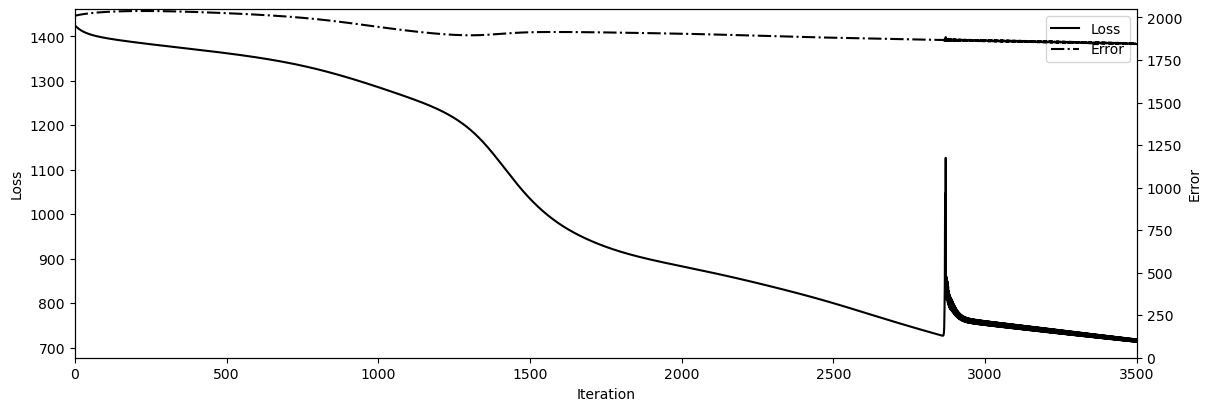

In [361]:
model.train(method='SGD', lr=0.01, iters=3500, plot=True, error='MSE', verbose=True);

Starting optimization using SGD
‣ Model: Exact
  ‣ Kernel: [GaussianConvolutionProcessKernel,GaussianConvolutionProcessKernel,GaussianConvolutionProcessKernel,GaussianConvolutionProcessKernel]
  ‣ Likelihood: GaussianLikelihood
‣ Channels: 1
‣ Parameters: 69
‣ Training points: 69
‣ Iterations: 500
  3500/4000   0:00:00  loss=     44.2807  error=  0.00207701
  4000/4000   0:00:02  loss=     44.2798  error=  0.00207421
Optimization finished in 2.437 seconds


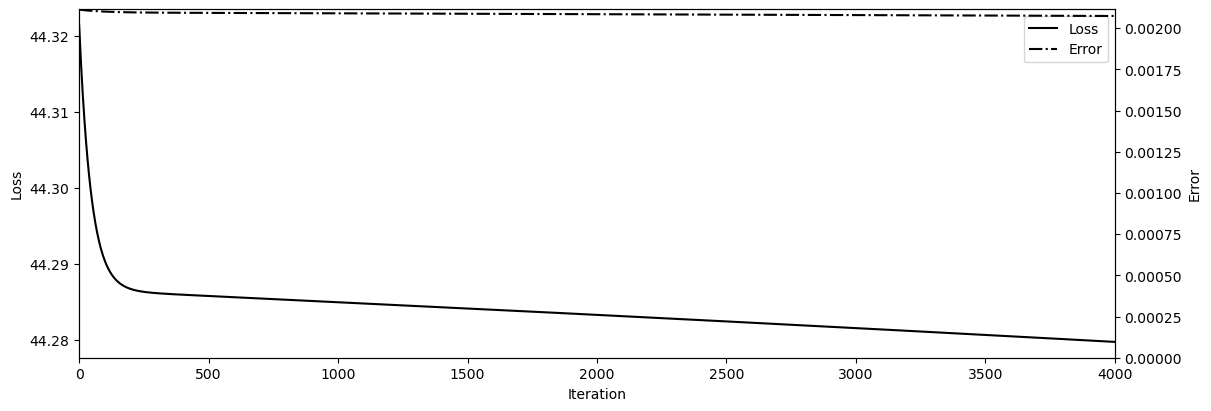

In [349]:
model.train(method='SGD', lr=0.01, iters=500, plot=True, error='MSE', verbose=True);

In [350]:
model.predict(X_test.values)[1]

array([0.3067556 , 0.30690228, 0.30655053, 0.30578816, 0.30676194,
       0.30668318, 0.30654698, 0.30678668, 0.30705052, 0.30674753,
       0.30637417, 0.30680454, 0.30682754, 0.30684626, 0.30685997,
       0.30673674, 0.30679356, 0.30682899])

In [351]:
np.mean((y_test.values.T-model.predict(X_test.values)[1])**2,axis=1)/X_test.shape[0]

array([6.10268744e+02, 4.96879142e+02, 1.33403596e+03, 1.35267787e-04])

(<Figure size 1200x1200 with 1 Axes>, <Axes: >)

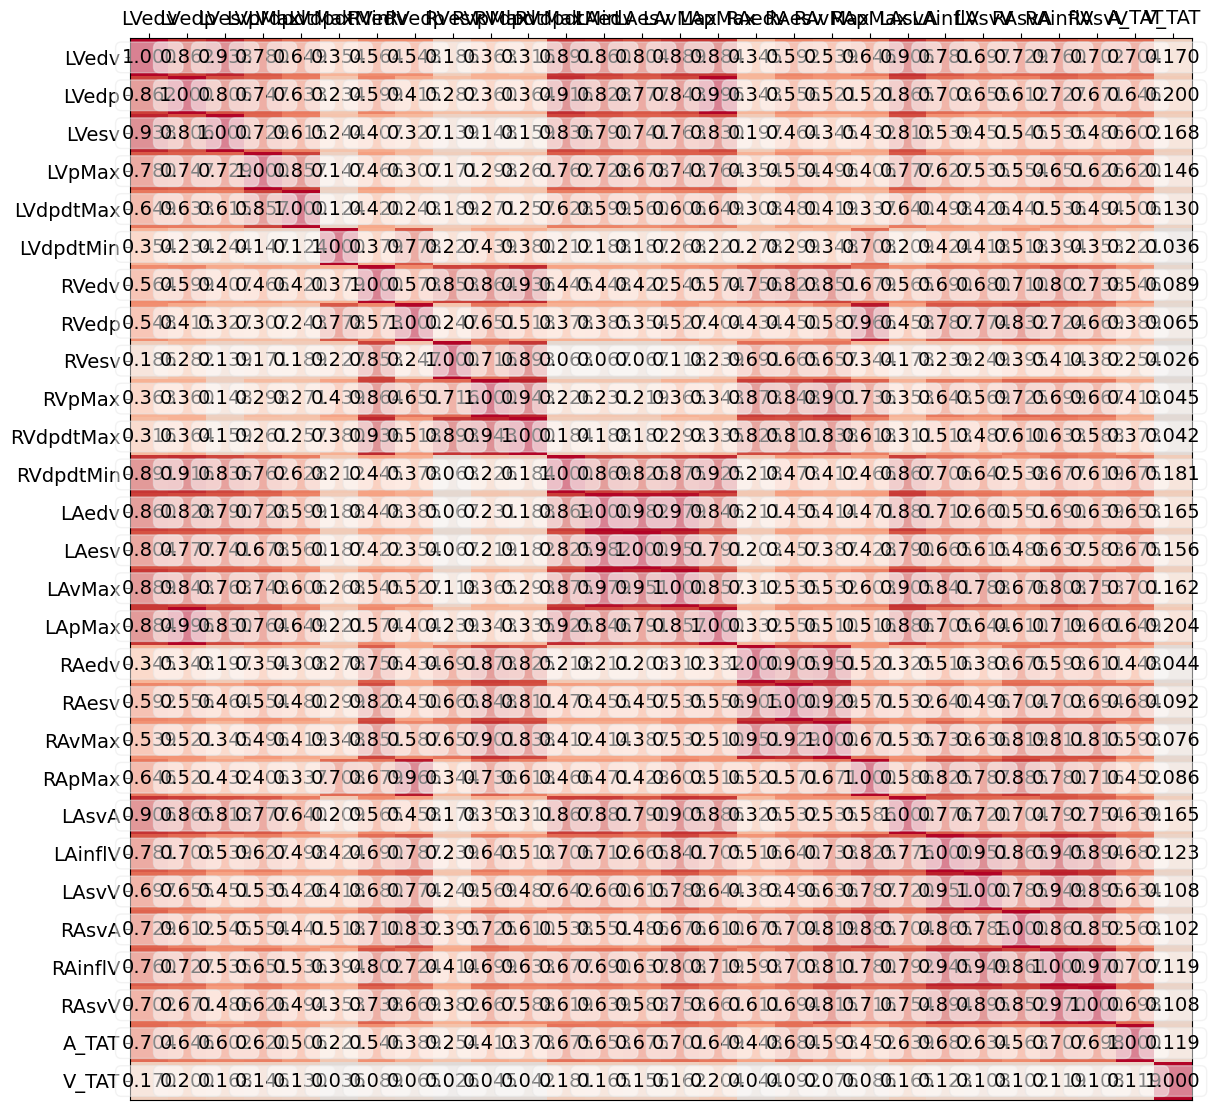

In [177]:
model.plot_correlation()

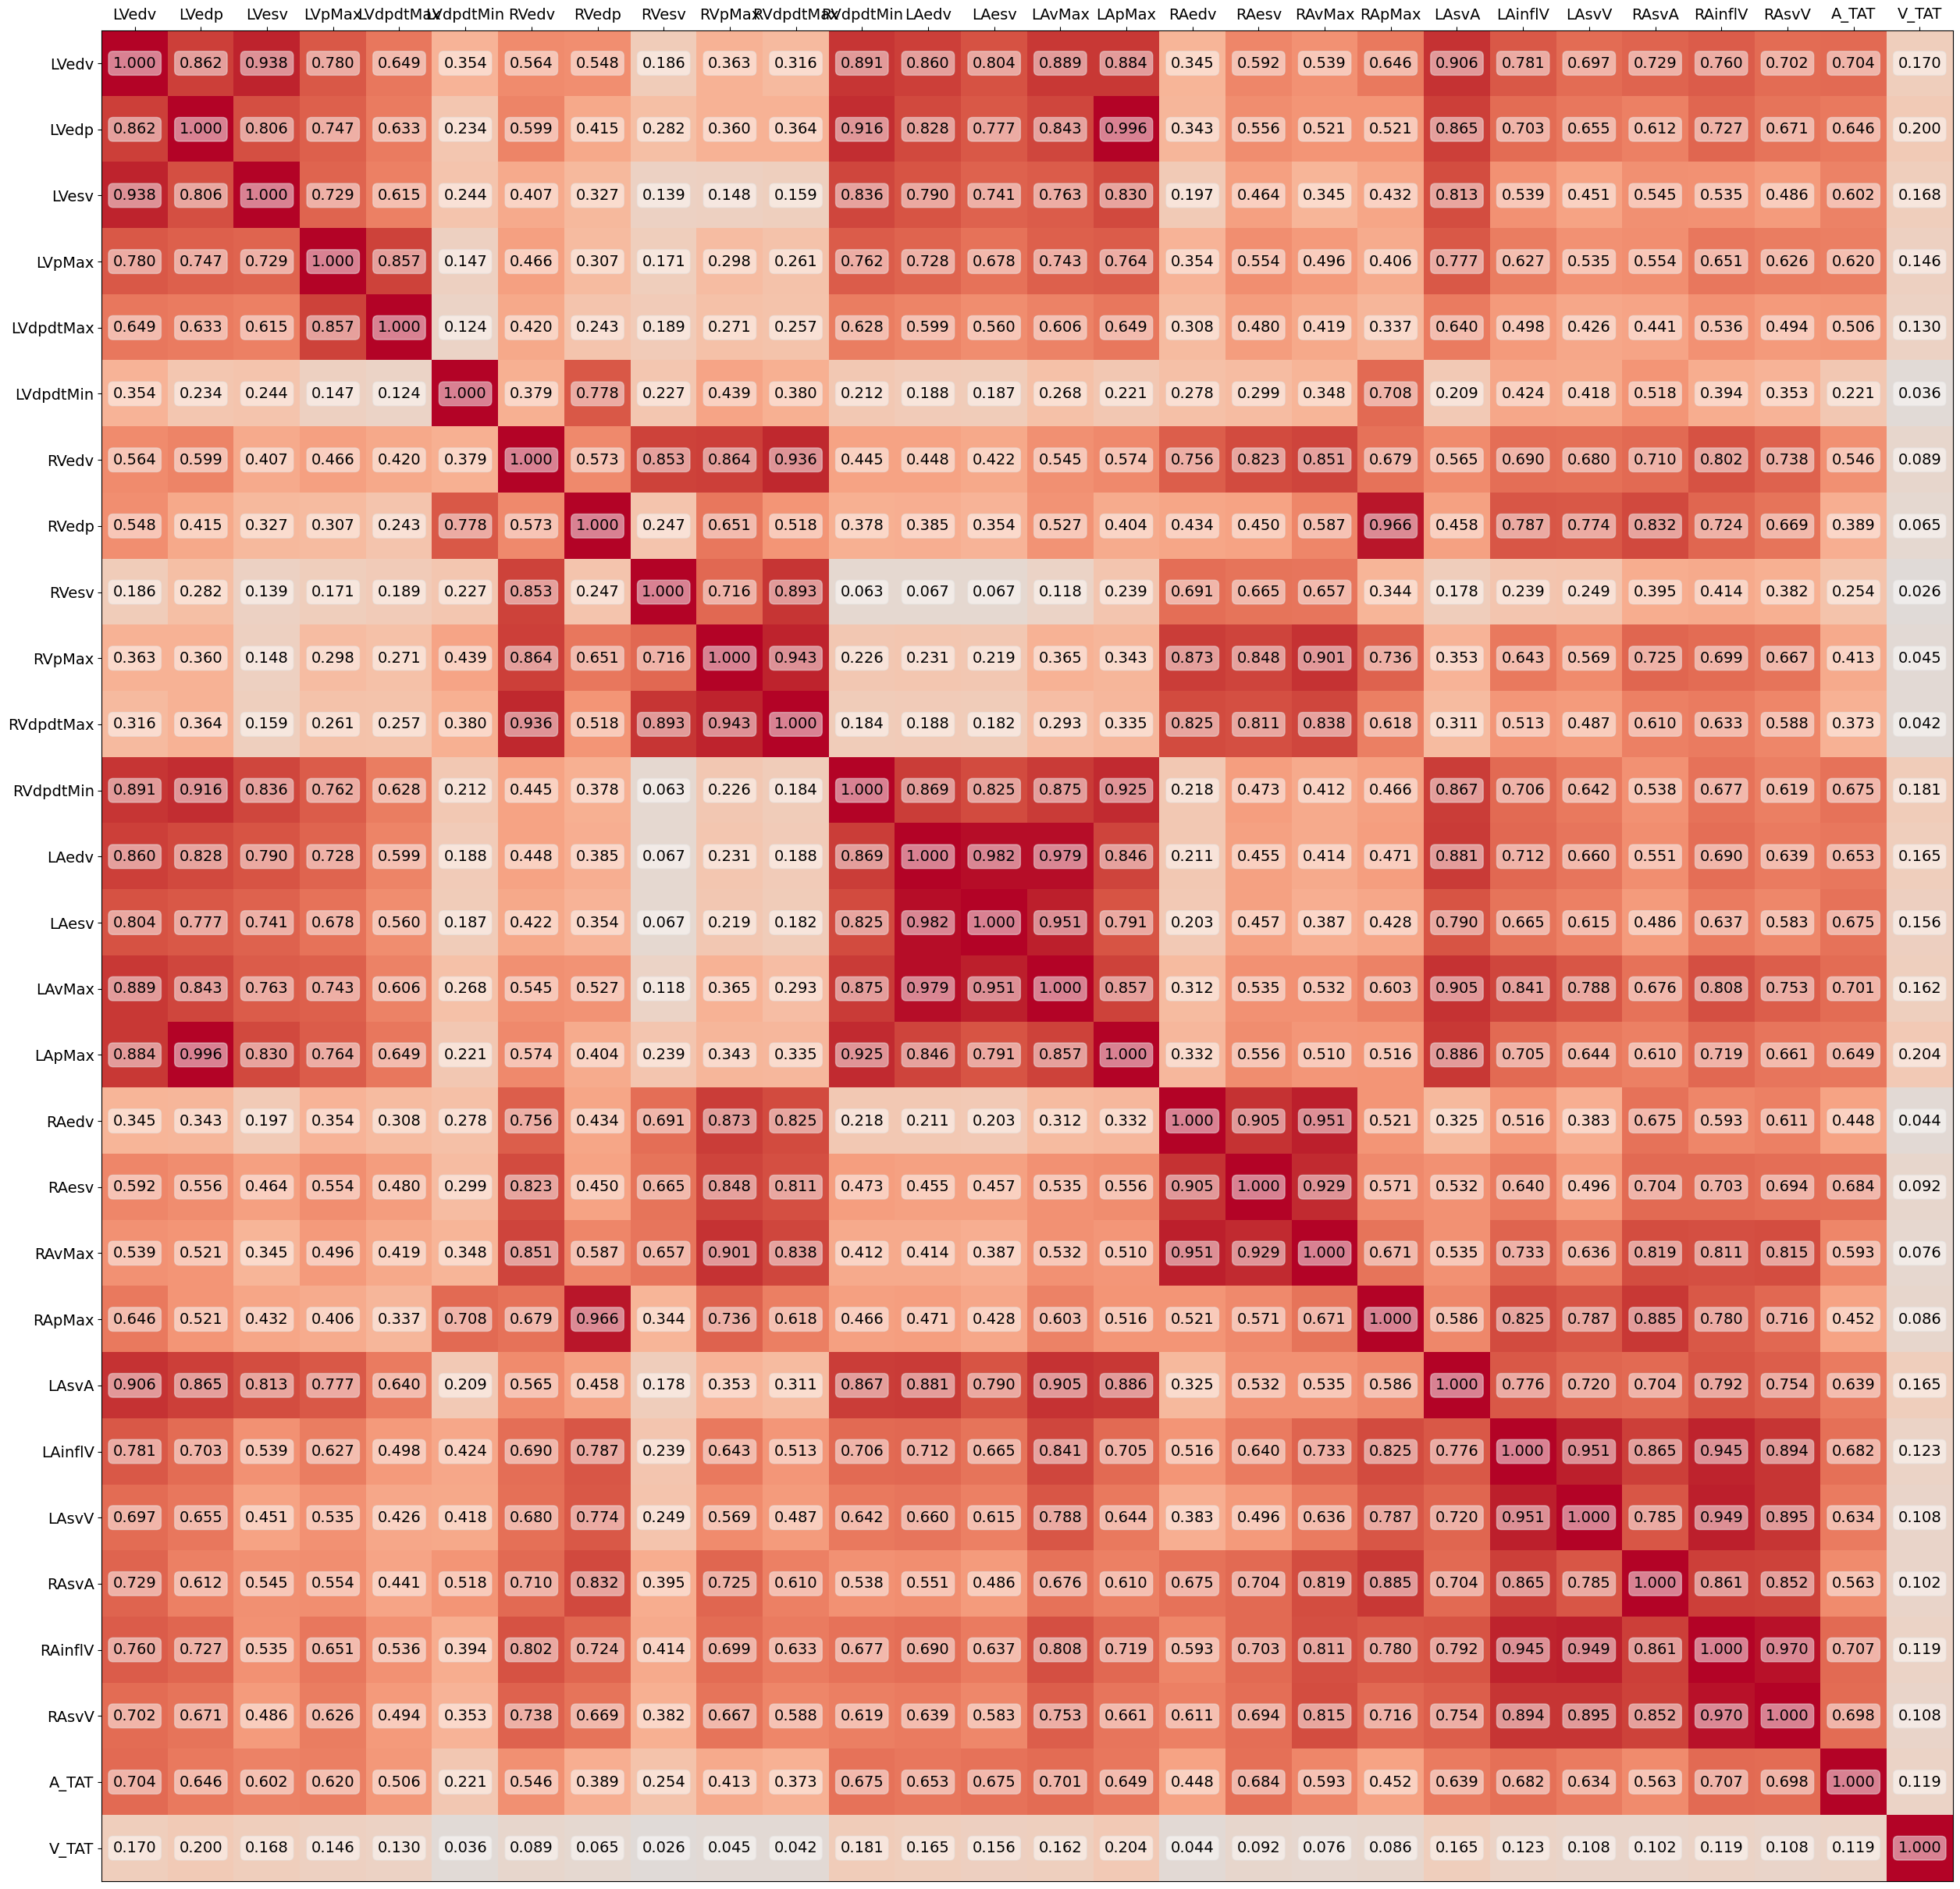

In [190]:
fig, ax = model.plot_correlation(figsize=(25, 25))

In [262]:
start=time.time()
emulator = GPE.ensemble(X_train,y_train,mean_func="linear",training_iter=500)

end = time.time()
print(end - start)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
15.349963188171387


In [207]:
from matplotlib import pyplot as plt

In [208]:
X_test

CV_ventricles  CV_atria     Rsys    Rpulm  a_ventricles  a_atria   EDP_lv  \
13       0.467505  0.937389  1.70404  1.61315       1.61984  3.93550  1.70868   
51       0.411168  0.806552  2.22592  1.61506       4.61831  3.32068  5.34888   
17       0.659609  0.860720  2.64259  2.70677       1.00155  4.08476  1.08002   
20       0.590966  0.304348  3.80092  3.76517       2.79257  4.13025  2.07563   
12       0.787557  0.347585  3.93953  3.66498       2.64604  2.31081  5.10721   
41       0.694628  0.482147  3.89395  1.04788       3.03173  2.53249  6.06477   
11       0.699967  0.640573  2.65993  2.25670       2.09928  3.02611  1.25726   
74       0.771325  0.978845  2.53865  1.06501       3.75601  3.22399  5.69728   
36       0.514725  0.435274  2.22155  1.78580       4.05656  2.23212  3.52061   
40       0.789712  0.974075  2.60407  1.03315       1.17635  4.86944  3.28191   
15       0.649804  0.366378  3.42754  1.76972       4.32856  1.58179  3.90305   
33       0.713332  0.520356  1.98012  3.23624       4.56459  3.25008  7.06437   
18       0.496981  0.797190  1.54376  2.49627       4.13130  4.18008  5.52565   
54       0.602005  0.824977  1.99665  2.99978       3.53177  2.63447  7.49720   
77       0.407686  0.537840  2.12478  1.61947       2.95755  2.74161  5.52344   
61       0.633311  0.474940  2.29262  1.37619       2.44618  4.70234  4.78130   
2        0.652384  0.610575  3.06834  1.55817       1.80784  3.96080  7.47750   
50       0.510252  0.327688  1.02831  1.47270       3.65468  1.21746  4.97025   

     EDP_rv  
13  1.49185  
51  2.55497  
17  5.70693  
20  5.16209  
12  3.70031  
41  2.16743  
11  1.55427  
74  7.29363  
36  2.54710  
40  4.33968  
15  4.40120  
33  1.41524  
18  5.42313  
54  2.73336  
77  2.81113  
61  4.92795  
2   7.07723  
50  2.50160

In [214]:
import cigp_v10 as cig

2.1.1


In [215]:
model = cig.cigp(torch.tensor(X_train.values),torch.tensor(y_train.values),normal_y_mode=1)

In [260]:
import time
start = time.time()


model.train_adam(niteration=500)



iter 0 nll:215.91870
iter 1 nll:272.53251
iter 2 nll:219.79398
iter 3 nll:229.57880
iter 4 nll:249.11088
iter 5 nll:236.72204
iter 6 nll:219.56820
iter 7 nll:216.99664
iter 8 nll:225.98059
iter 9 nll:232.36712
iter 10 nll:229.49038
iter 11 nll:221.60856
iter 12 nll:216.36657
iter 13 nll:217.68231
iter 14 nll:222.57754
iter 15 nll:224.82116
iter 16 nll:222.16414
iter 17 nll:217.82631
iter 18 nll:215.97058
iter 19 nll:217.55018
iter 20 nll:220.08192
iter 21 nll:220.69543
iter 22 nll:218.91715
iter 23 nll:216.63827
iter 24 nll:215.96648
iter 25 nll:217.15591
iter 26 nll:218.51580
iter 27 nll:218.42767
iter 28 nll:217.09699
iter 29 nll:216.02445
iter 30 nll:216.17681
iter 31 nll:217.06527
iter 32 nll:217.52179
iter 33 nll:217.04850
iter 34 nll:216.22733
iter 35 nll:215.93289
iter 36 nll:216.33827
iter 37 nll:216.80649
iter 38 nll:216.73046
iter 39 nll:216.23898
iter 40 nll:215.92721
iter 41 nll:216.08189
iter 42 nll:216.40066
iter 43 nll:216.44609
iter 44 nll:216.17934
iter 45 nll:215.9413

iter 497 nll:215.91870
iter 498 nll:215.91870
iter 499 nll:215.91870
0.4070570468902588


In [258]:
(torch.sum((model.forward(torch.tensor(X_test.values))[0]-torch.tensor(y_test.values))**2,axis=0))/y_test.values.shape[0]

tensor([6.0312e+00, 2.6988e-02, 7.9963e+00, 3.4985e+00, 6.0794e+03, 3.5051e+02,
        6.0183e+00, 8.4694e-03, 4.7400e+00, 2.7780e-02, 7.3039e+01, 2.3244e+01,
        5.8239e-01, 3.4617e-01, 9.6969e-01, 2.3944e-02, 5.7691e-01, 4.6414e-01,
        8.1937e-01, 7.0259e-03, 1.3212e-01, 2.1868e-01, 4.0148e-01, 1.3588e-01,
        1.4199e-01, 1.8035e-01, 1.3932e+02, 3.3528e+01], dtype=torch.float64,
       grad_fn=<DivBackward0>)

In [224]:
mogptMSE = np.array([9.10333333e-01, 1.33455636e-02, 8.78157403e-01, 6.69582124e-01,
       3.70024071e+02, 1.23460430e+02, 6.35753356e-01, 6.52791491e-04,
       3.76409392e-01, 5.31805275e-01, 1.71110574e+02, 5.49810697e+00,
       1.05649088e-01, 7.97417780e-02, 1.55348111e-01, 1.24083716e-02,
       5.45010526e-02, 5.65038223e-02, 1.02820944e-01, 1.11955787e-03,
       2.06413166e-02, 1.92173725e-02, 5.43121107e-02, 2.30204748e-02,
       1.96869906e-02, 1.69456459e-02, 1.63021757e+01, 1.57392304e+00])

In [230]:
GPMSE = emulator.MSE(X_test,y_test).detach().numpy()
CIGMSE=((torch.sum((model.forward(torch.tensor(X_test.values))[0]-torch.tensor(y_test.values))**2,axis=0))/y_test.values.shape[0]).detach().numpy()

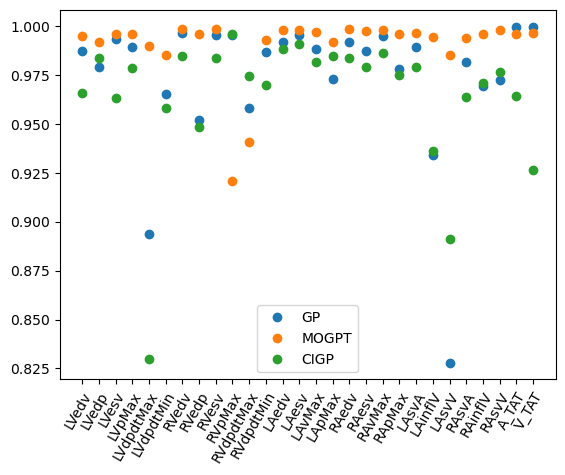

In [256]:
fig, ax = plt.subplots()



im=plt.plot(1-GPMSE/np.var(y_test,axis=0),'o')
plt.plot(1-mogptMSE/np.var(y_test,axis=0),'o')
plt.plot(1-CIGMSE/np.var(y_test,axis=0),'o')
plt.legend(('GP','MOGPT','CIGP'))


plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

In [196]:
np.mean((y_test.values.T-model.predict(X_test.values)[1])**2,axis=1)/X_test.shape[0]

array([6.21002976e-01, 9.25783220e-03, 7.19937386e-01, 4.97249422e-01,
       3.69508920e+02, 5.33032505e+01, 4.64374559e-01, 5.02259612e-04,
       2.97463362e-01, 3.96262174e-02, 3.40679822e+01, 4.80134093e+00,
       6.65335292e-02, 5.16813463e-02, 1.09822059e-01, 7.64626100e-03,
       4.79548606e-02, 4.42720160e-02, 6.21832473e-02, 6.09749396e-04,
       1.40105144e-02, 2.43447394e-02, 6.66730345e-02, 1.68011875e-02,
       1.29166249e-02, 1.31994583e-02, 5.45991126e+00, 4.64526423e-01])

In [237]:
np.var(y_test,axis=0)

LVedv          176.384178
LVedp            1.647276
LVesv          219.119256
LVpMax         164.972762
LVdpdtMax    35692.135802
LVdpdtMin     8364.570988
RVedv          396.686761
RVedp            0.163505
RVesv          292.241665
RVpMax           6.709824
RVdpdtMax     2890.098765
RVdpdtMin      777.987654
LAedv           48.782083
LAesv           38.519744
LAvMax          53.121262
LApMax           1.550892
RAedv           35.023317
RAesv           22.311691
RAvMax          58.582710
RApMax           0.281065
LAsvA            6.331531
LAinflV          3.425303
LAsvV            3.685479
RAsvA            3.775565
RAinflV          4.927222
RAsvV            7.731950
A_TAT         3906.348877
V_TAT          456.323873
dtype: float64

In [245]:
y_all.iloc[:,[4]].max()

LVdpdtMax    2087
dtype: int64

In [246]:
y_all.iloc[:,[4]].min()

LVdpdtMax    1208
dtype: int64

In [249]:
y_all.iloc[:,[4]].std()

LVdpdtMax    190.187491
dtype: float64